# Computing reaction ranges of spiral tips 
Tim Tyree<br>
3.19.2021

In [1]:
from lib.my_initialization import *
from lib import *
from lib.utils.merge_cloud_results import *
import seaborn as sns
# from scipy.interpolate import CubicSpline
from scipy.interpolate import splprep, splev
import matplotlib
%load_ext autoreload
%autoreload 2

In [2]:
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# (ignore) don't make a nice snapshot

In [3]:
#load poster child csv
file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic018.21_traj_sr_600_mem_0.csv'
ic_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-out/ic018.21.npz'

In [4]:
txt=load_buffer(ic_fn)
# txt.shape
results_folder=f"{nb_dir}/Data/reaction-range-data"
if not os.path.exists(results_folder):
    os.mkdir(results_folder)
K_o=3.8
diffCoef=0.001
tmin_sec=0.1
#cython accelerated time integration of LR model
from lib.routines.generate_tip_logs_LR_model_cy import *
from lib.routines.kwargs_LR_model_cy import get_kwargs
kwargs = get_kwargs(ic_fn,results_folder=results_folder)
kwargs['tmax']=tmin_sec;print(tmin_sec)
kwargs['diffCoef']=diffCoef
kwargs['K_o']=K_o

0.1


In [5]:
dt=0.01
dsdpixel=0.025
width=200;height=200
printing=True
dt, one_step_map = get_one_step_map(nb_dir,dt=dt,width=width,height=height,**kwargs)
# dt, one_step_map = get_one_step_map(nb_dir,dt,**kwargs)
# dt, one_step_map = get_one_step_map(nb_dir,dt,dsdpixel,width,height,**kwargs)
# dt, one_step_map = get_one_step_map(nb_dir,dt,**kwargs)
txt_Istim_none=np.zeros(shape=(width,height), dtype=np.float64, order='C')
tmin_early_stopping=tmin_sec*10**3
t=0.
txt=load_buffer(ic_fn).astype('float64')
if printing:
    print(f"integrating to time t={tmin_early_stopping:.3f} ms without recording with dt={dt:.3f} ms.")
    print(f"long run times ~2 minutes expected...")
while (t<tmin_early_stopping):
    one_step_map(txt,txt_Istim_none)
    t+=dt
#precompute anything that needs precomputing
compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)


integrating to time t=100.000 ms without recording with dt=0.010 ms.
long run times ~2 minutes expected...


KeyboardInterrupt: 

In [ ]:
level1=-50.
level2=0.
#TODO: track trajectory up to some time at a high time resolution
#check for any tips being present
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
img=inVc[...,0]
dimgdt=dVcdt[...,0]
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)
n_tips=dict_out['n']#skip this trial if no spiral tips are present

In [ ]:
txt_tmin_sec=txt.copy()
beep(4)

In [ ]:
#verify whether the apparent tips agree with the recorded tips
df_recorded = pd.read_csv(file)

In [ ]:
t

In [ ]:
dict_out['x']


In [ ]:
df_recorded[(df_recorded.t>=t-0.5)&(df_recorded.t<=t+0.5)]

In [ ]:
df_recorded

In [ ]:
while (t<tmin_early_stopping+0.1*20):
    one_step_map(txt,txt_Istim_none)
    t+=dt

In [ ]:
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
img=inVc[...,0]
dimgdt=dVcdt[...,0]
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)
n_tips=dict_out['n']#skip this trial if no spiral tips are present
dict_out['x']

In [ ]:
sorted(df_recorded[df_recorded.frame==15].x.values)
# list(df_recorded[(df_recorded.t>=t-0.5)&(df_recorded.t<=t+0.5)]['x'].values)

In [ ]:
dict_out['x']

# DO analyze the existing spiral tip trajectory data

# plot naive reaction ranges at death and birth

## show birth/death range for LR model with dt=0.4ms

In [ ]:
#load poster child csv
file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic018.21_traj_sr_600_mem_0.csv'
# ic_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-out/ic018.21.npz'
df=pd.read_csv(file)
df.head()

In [ ]:
def compute_DT(df,round_t_to_n_digits=3):
    '''DT is the time between two observations'''
    DT=np.around(df[(df.frame==1)].t.values[0]-df[(df.frame==0)].t.values[0],round_t_to_n_digits)
    return DT

In [ ]:
#compute interactions
df_interactions=compute_df_interactions(file,DS=5./200.)
df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

In [ ]:
fontsize=16
#plot naive range at death and birth
plt.hist(DS*df_interactions.rT.values,bins=10,label='range at death',alpha=0.7,color='red',density=True)
plt.hist(DS*df_interactions.r0.values,bins=20,label='range at birth',alpha=0.3,color='green',density=True)
plt.ylabel('probability density',fontsize=fontsize)
plt.xlabel('reaction range (cm)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.show()

In [ ]:
print(f"for this trial,")
print(f"\tdeath range was {np.mean(death_ranges):.3f} +- {np.std(death_ranges):.3f} cm")
print(f"\tbirth range was {np.mean(birth_ranges):.3f} +- {np.std(birth_ranges):.3f} cm")
print(f"\ttime between two frames was {DT} ms")

^this is for the LR model

## show birth/death range for LR model with dt=?? ms

In [ ]:
# file=f"{nb_dir}/Data/initial-conditions-suite-2/ds_5_param_set_8_V_0.5_fastkernel/ic_200x200.001.13_traj_sr_400_mem_0.csv"
# file=f"{nb_dir}/Data/initial-conditions-suite-1/ds_5_param_set_8/trajectories/ic_200x200.104.32_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv"

#load poster child csv
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic018.21_traj_sr_600_mem_0.csv'
# ic_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-out/ic018.21.npz'
df=pd.read_csv(file)
df.head()

In [ ]:
def compute_DT(df,round_t_to_n_digits=3):
    '''DT is the time between two observations'''
    DT=np.around(df[(df.frame==1)].t.values[0]-df[(df.frame==0)].t.values[0],round_t_to_n_digits)
    return DT

In [ ]:
DS=5./200.
DT=compute_DT(df,round_t_to_n_digits=3);print(DT)
#compute interactions
df_interactions=compute_df_interactions(file,DS=DS)
# df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

In [ ]:
death_ranges.shape


In [ ]:
fontsize=16
#plot naive range at death and birth
plt.hist(DS*df_interactions.rT.values,bins=10,label='range at death',alpha=0.7,color='red',density=True)
plt.hist(DS*df_interactions.r0.values,bins=20,label='range at birth',alpha=0.3,color='green',density=True)
plt.ylabel('probability density',fontsize=fontsize)
plt.xlabel('reaction range (cm)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.show()

print(f"for this trial,")
print(f"\tdeath range was {np.mean(death_ranges):.3f} +- {np.std(death_ranges):.3f} cm")
print(f"\tbirth range was {np.mean(birth_ranges):.3f} +- {np.std(birth_ranges):.3f} cm")
print(f"\ttime between two frames was {DT} ms")



## show birth/death range for FK model with dt=1.0 ms

In [ ]:
from lib.routines.return_reaction_ranges_from_folder import *

In [ ]:
input_fn=search_for_file()


In [ ]:
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_10_Ko_7/trajectories/ic001.21_traj_sr_400_mem_0.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_10_Ko_7/trajectories/ic010.12_traj_sr_400_mem_0.csv"
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/trajectories/ic004.33_traj_sr_600_mem_0.csv"
# input_fn=f"{nb_dir}/Data/initial-conditions-suite-2/ds_5_param_set_8_V_0.5_fastkernel/ic_200x200.001.13_traj_sr_400_mem_0.csv"


# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-300x300/ds_7.5_param_set_8/Log/ic300x300.0.6_traj_sr_600_mem_0.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-lr-300x300/param_qu_tmax_30/trajectories/ic300x300.3.3_traj_sr_600_mem_0.csv"
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-lr-600x600/param_qu_tmax_30/Log/ic600x600.0.1_traj_sr_1200_mem_0.csv"
df=pd.read_csv(input_fn)
DT=compute_DT(df,round_t_to_n_digits=3);print(DT)

width=200.
# df=pd.read_csv(input_fn)
# DT=compute_DT(df,round_t_to_n_digits=3);print(DT)
bin_edges=get_bin_edges(input_fn,ds=5.,width=width,nbins=100)

#TODO: use dask.bag on UB
input_fn_lst=[input_fn]
for input_fn in input_fn_lst:
    bin_count_death, bin_count_birth,DT=comp_bdrange_bincounts(input_fn,bin_edges,ds=5.,width=200.)

#TODO: reduce using dask.bag
# bin_count_death=sum_bin_count(bin_count_death1,bin_count_death2)
# bin_count_birth=sum_bin_count(bin_count_birth1,bin_count_birth2)

range_values,brate_values,drate_values=comp_bdrates_by_bin(bin_count_birth,bin_count_death,bin_edges,DT)
# TODO: put ^this in a routine that asks for a trajectory folder as input
# print(f"for this trial,")
# print(f"\tdeath range was {np.mean(death_ranges):.3f} +- {np.std(death_ranges):.3f} cm")
# print(f"\tbirth range was {np.mean(birth_ranges):.3f} +- {np.std(birth_ranges):.3f} cm")
# print(f"\ttime between two frames was {DT} ms")

In [ ]:
file_out=f"{nb_dir}/Data/initial-conditions-lr-600x600/param_qu_tmax_30/ic0.1_traj_sr_1200_mem_0_rate_histogram.csv"
df_out=pd.DataFrame({
    'r':range_values,
    'brate':brate_values,
    'drate':drate_values
})
df_out.to_csv(file_out,index=False)
print(file_out)

In [ ]:
beep(4)

In [ ]:
# death_ranges,birth_ranges,DT=return_bd_ranges(input_fn,DS,round_t_to_n_digits=3)
DT=compute_DT(df,round_t_to_n_digits=3)
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

In [ ]:
print(input_fn)
fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))

#for deaths
c,death_location,death_scale=genextreme.fit(death_ranges)
x=range_values
ax.plot(x, genextreme.pdf(x, c,loc=death_location,scale=death_scale)*500,
       'r-', lw=5, alpha=0.6, label='genextreme pdf')
ax.set_xlim([0,1])
print(f"death fit: {c,death_location,death_scale}")
#for births
cbirth,birth_location,birth_scale=genextreme.fit(birth_ranges)
ax.plot(x, genextreme.pdf(x, cbirth,loc=birth_location,scale=birth_scale)*500,
       'g-', lw=5, alpha=0.6, label='genextreme pdf')

print(f"birth fit: {cbirth,birth_location,birth_scale}")
plt.show()


In [ ]:
# def PlotRangesBD(bin_ranges,brate_values,drate_values,fontsize=16,figsize=(7,5)):
#     '''plots results of what was aggregated from a large number of tips'''
#     fig,ax=plt.subplots(figsize=figsize)
#     ax.bar(x=bin_ranges,height=drate_values,align='center',width=bin_width,alpha=0.7,color='red',label='pair annihilation rate')
#     ax.bar(x=bin_ranges,height=brate_values,align='center',width=bin_width,alpha=0.7,color='green',label='pair creation rate')
#     ax.set_xlabel('apparent range (cm)',fontsize=fontsize)
#     ax.set_ylabel('reaction rate (Hz)',fontsize=fontsize)
#     ax.legend(fontsize=fontsize)
#     ax.tick_params(axis='both', which='major', labelsize=fontsize)
#     ax.tick_params(axis='both', which='minor', labelsize=0)
#     ax.set_title(f"{DT_sec:.4f} seconds between two frames",fontsize=fontsize)
#     return fig,ax

In [ ]:
fontsize=16
#plot naive range at death and birth
plt.hist(death_ranges,bins=10,label='range at death',alpha=0.7,color='red',density=True)
plt.hist(birth_ranges,bins=20,label='range at birth',alpha=0.3,color='green',density=True)
plt.ylabel('probability density',fontsize=fontsize)
plt.xlabel('reaction range (cm)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.show()
print(f"for this trial,")
print(f"\tdeath range was {np.mean(death_ranges):.3f} +- {np.std(death_ranges):.3f} cm")
print(f"\tbirth range was {np.mean(birth_ranges):.3f} +- {np.std(birth_ranges):.3f} cm")
print(f"\ttime between two frames was {DT} ms")

In [ ]:
print(f"for this trial,")
print(f"\tdeath range was {np.mean(death_ranges):.3f} +- {np.std(death_ranges):.3f} cm")
print(f"\tbirth range was {np.mean(birth_ranges):.3f} +- {np.std(birth_ranges):.3f} cm")
print(f"\ttime between two frames was {DT} ms")


^this is for the FK model

# visualize the COM frame/trajectory versus time just before death
- TODO: compute annihilation speed near death in the COM frame
- TODO: plot ^that.  does an apparent range of acceleration/certain annihilation emerge?
- TODO: how often do spiral tips come closer than distance X and not promptly annihilate
- TODO: scatter plot of mean (stdev) interaction range, 
     - where each dot is 1 trial.  
     - xcoord = mean interaction range
     - ycoord = stdev interaction range
     - marker shape = type of trial

In [ ]:
#select from the longest lived particles
index_longest=3
DT=compute_DT(df)
trajectory_lifetimes=DT*df.groupby('particle').count().sort_values(by='x',ascending=False).x
pid=int(trajectory_lifetimes.head(index_longest).index.values[-1])
pid

In [ ]:
#identify the death partner of that particle
df_interactions[df_interactions.pid==pid]

In [ ]:
#compile distance metric
width=200;height=200;DS=0.025
distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)

In [ ]:
n_frames=700#30

#compute the COM and the range between two spiral tips just before they annihilate
pid_other=df_interactions[df_interactions.pid==pid].pid_deathmate.values[-1]
d1=df[df.particle==pid].tail(n_frames).copy()
d1u=unwrap_traj_and_center(d1, width, height, DS)
d2=df[df.particle==pid_other].tail(n_frames).copy()
d2u=unwrap_traj_and_center(d2, width, height, DS)

In [ ]:
#compute the shift between these two tips in their unwrapped coordinates
disp_1=(d1.head(1)-d1u.head(1))[['x','y']].values.flatten()
disp_2=(d2.head(1)-d2u.head(1))[['x','y']].values.flatten()

In [ ]:
#compute individual particle speeds and truncate at final jump
x_values=d1u.x.values;y_values=d1u.y.values;t_values=d1u.t.values;
jump_lst,speed_lst=find_jumps_non_pbc(x_values,y_values,
    width,height,DS,DT,distance_L2_pbc=distance_L2_pbc,jump_thresh=30)
if len(list(jump_lst))>0:
    s1_values=np.array(speed_lst[jump_lst[-1]+1:])#*10**3 #cm per second
    t1_values=np.array(t_values[jump_lst[-1]+2:])-DT/2 #ms time before death
else:
    s1_values=np.array(speed_lst)#*10**3 #cm per second
    t1_values=np.array(t_values[1:]) #ms time before death
print(jump_lst)
#slice dataframe to include only those observations after any jumps
d1u=d1u[d1u.t>=t1_values[0]].copy()
d1=d1[d1.t>=t1_values[0]].copy()

#compute individual particle speeds and truncate at final jump
x_values=d2u.x.values;y_values=d2u.y.values;t_values=d2u.t.values;
jump_lst,speed_lst=find_jumps_non_pbc(x_values,y_values,
    width,height,DS,DT,distance_L2_pbc=distance_L2_pbc,jump_thresh=30)
if len(list(jump_lst))>0:
    s2_values=np.array(speed_lst[jump_lst[-1]+1:])#*10**3 #cm per second
    t2_values=np.array(t_values[jump_lst[-1]+2:]) #ms time before death
else:
    s2_values=np.array(speed_lst)#*10**3 #cm per second
    t2_values=np.array(t_values[1:])-DT/2 #ms time before death
print(jump_lst)

#slice dataframe to include only those observations after any jumps
d2u=d2u[d2u.t>=t2_values[0]].copy()
d2=d2[d2.t>=t2_values[0]].copy()

In [ ]:
#compute the COM and the range between two spiral tips just before they annihilate
xy_final_com=(d1.tail(1).values+d2.tail(1).values).flatten()[2:4]/2
xy_final_range=(d1.tail(1).values-d2.tail(1).values).flatten()[2:4]
final_range=np.linalg.norm(xy_final_range)*DS

In [ ]:
#plot that annihilation event in the transformed coordinates
x1_values=d1u.x.values-d1u.x.values[-1]+xy_final_range[0]/2
y1_values=d1u.y.values-d1u.y.values[-1]+xy_final_range[1]/2
c1_values=d1u.t.values
x2_values=d2u.x.values-d2u.x.values[-1]-xy_final_range[0]/2
y2_values=d2u.y.values-d2u.y.values[-1]-xy_final_range[1]/2
c2_values=d2u.t.values

#plot that annihilation event in the transformed death coordinates
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x1_values*DS,y1_values*DS,c=c1_values,cmap='Greens')
ax.scatter(x2_values*DS,y2_values*DS,c=c2_values,cmap='Blues')
ax.scatter([0],[0],c='red',marker='*',s=500)
# ax.scatter([xy_final_com[0]],[xy_final_com[1]],c='red',marker='*',s=500)
ax.set_ylabel('y (cm)',fontsize=fontsize)
ax.set_xlabel('x (cm)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.grid('on')
ax.set_aspect('equal')
plt.show()

In [ ]:
lifetime_considered_1=x1_values.shape[0]*DT
lifetime_considered_2=x2_values.shape[0]*DT
print(f"lifetime considered for green was {lifetime_considered_1} ms.")
print(f"lifetime considered for blue was {lifetime_considered_2} ms.")

In [ ]:
#truncate both trajectories to briefest of the two
# tmin=np.min(np.hstack([t1_values,t2_values]))
tmin=np.max([np.min(t1_values),np.min(t2_values)])
boo1=tmin<=t1_values
boo2=tmin<=t2_values
x1_values=x1_values[boo1]
y1_values=y1_values[boo1]
c1_values=c1_values[boo1]
x2_values=x2_values[boo2]
y2_values=y2_values[boo2]
c2_values=c2_values[boo2]

In [ ]:
#compute the range/displacement between the two spiral tips at each time point just before death
x=(x1_values+x2_values)/2
y=(y1_values+y2_values)/2
t_values=c1_values
#model ^that displacement time series using a Bezier curve
tck, u = splprep([x, y],u=t_values, s=0)
new_points = splev(u, tck,0)
#notice that (i) we force interpolation by using s=0, (ii) the parameterization, u, is generated automatically. Now plot the result:

In [ ]:
#plot COM just before death
fig, ax = plt.subplots()
ax.scatter(x, y,s=10,c='r')
ax.plot(new_points[0], new_points[1], 'r-')
ax.set_ylabel('y (pixels)',fontsize=fontsize)
ax.set_xlabel('x (pixels)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.grid('on')
ax.set_aspect('equal')
ax.set_title('COM vector\njust before death',fontsize=fontsize)
plt.show()

In [ ]:
#compute the range/displacement between the two spiral tips at each time point just before death
delta_x_values=x1_values-x2_values
delta_y_values=y1_values-y2_values
x=delta_x_values
y=delta_y_values
t_values=c1_values
#model ^that displacement time series using a Bezier curve
tck, u = splprep([x, y],u=t_values, s=0)
new_points = splev(u, tck,0)#
#noice that (i) we force interpolation by using s=0, (ii) the parameterization, u, is generated automatically. Now plot the result:

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x,y,c=c1_values,cmap='Blues')
ax.plot(new_points[0], new_points[1], 'r-')
ax.set_ylabel('y (pixels)',fontsize=fontsize)
ax.set_xlabel('x (pixels)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.grid('on')
ax.set_aspect('equal')
ax.set_title('displacement vector\njust before death',fontsize=fontsize)
plt.show()

In [ ]:
#compute speed as the magnitude of the first derivative of ^that Bezier curve versus time
d_new_points_dt = splev(u, tck,1)
speed_values=np.linalg.norm(np.stack(d_new_points_dt),axis=0)*DS

In [ ]:
# #checked that the first speed listed agrees the first speed resulting from the above
# dxdt_init=d_new_points_dt[0][0]
# dydt_init=d_new_points_dt[1][0]
# np.linalg.norm([dxdt_init,dydt_init])*DS

In [ ]:
u_values=np.arange(np.min(u),np.max(u),.1)
d_new_points_dt = splev(u_values, tck,1)
speed_values=np.linalg.norm(np.stack(d_new_points_dt),axis=0)*DS*10**3

In [ ]:
speed_values_naive=np.linalg.norm(np.diff(np.stack([delta_x_values,delta_y_values])),axis=0)*DS/DT*10**3

In [ ]:
# #compute speed of each particle just before death
# dd1=d1u.diff()
# d1['speed']=(dd1.x**2+dd1.y**2)*DS/DT*10**3
# dd2=d2u.diff()
# d2['speed']=(dd2.x**2+dd2.y**2)*DS/DT*10**3

# s1_values=d1.dropna().speed.values
# s2_values=d2.dropna().speed.values
# t1_values=d1.dropna().t.values
# t2_values=d2.dropna().t.values

In [ ]:
#plot relative speed just before death
tf=u_values[-1]
fig, ax = plt.subplots()
ax.plot(u_values-tf, speed_values,label='from spline fit')
ax.plot(c1_values[1:]-tf-DT/2, speed_values_naive,label='naive')
# #plot absolute speeds just before death
# plt.plot(t1_values-tf,s1_values,label='particle A')
# plt.plot(t2_values-tf,s2_values,label='particle B')

ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('relative speed (cm/s)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.legend(fontsize=fontsize)
# ax.set_title('COM vector\njust before death',fontsize=fontsize)
plt.show()

In [ ]:
#plot relative speed just before death
#plot speeds for long time scales, and show whether they only react whenever speed crosses a thershold
tf=u_values[-1]
fig, ax = plt.subplots()
# ax.plot(u_values-tf, speed_values,label='from spline fit')
# ax.plot(c1_values[1:]-tf-DT/2, speed_values_naive,label='naive')
#plot absolute speeds just before death
plt.plot(t1_values-tf,s1_values,label='particle A')
plt.plot(t2_values-tf,s2_values,label='particle B')

ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('lab frame speed (cm/s)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.legend(fontsize=fontsize)
# ax.set_title('COM vector\njust before death',fontsize=fontsize)
plt.show()

In [ ]:
#compute range versus time leading up to death
range_values=np.sqrt(delta_x_values**2+delta_y_values**2)*DS

In [ ]:
#plot relative range just before death
tf=u_values[-1]
fig, ax = plt.subplots()
# ax.plot(u_values-tf, range_values,label='from spline fit')
ax.plot(c1_values-tf, range_values,label='_Hidden')
# #plot absolute speeds just before death
# plt.plot(t1_values-tf,s1_values,label='particle A')
# plt.plot(t2_values-tf,s2_values,label='particle B')

ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('range (cm)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
# ax.set_title('COM vector\njust before death',fontsize=fontsize)
plt.show()

In [ ]:
#TODO: plot relative speeds for several trajectories
#TODO: plot ensemble averaged relative speeds for many trials
#TODO: test whether tips only react when their relative range crosses a threshold
#TODO: decide what the (cleanest) measure of reaction will be


# Visualize timeseries data leading up to many deaths
- --> critical reaction range, $X>0$, appears to exist

In [ ]:
def compute_death_timeseries(df,pid,pid_other,DT,n_frames_max=1000):
    #compute the COM and the range between two spiral tips just before they annihilate
    d1=df[df.particle==pid].tail(n_frames_max).copy()
    d1u=unwrap_traj_and_center(d1, width, height, DS)
    d2=df[df.particle==pid_other].tail(n_frames_max).copy()
    d2u=unwrap_traj_and_center(d2, width, height, DS)

    #compute the shift between these two tips in their unwrapped coordinates
    disp_1=(d1.head(1)-d1u.head(1))[['x','y']].values.flatten()
    disp_2=(d2.head(1)-d2u.head(1))[['x','y']].values.flatten()

    #compute individual particle speeds and truncate at final jump
    x_values=d1u.x.values;y_values=d1u.y.values;t_values=d1u.t.values;
    jump_lst,speed_lst=find_jumps_non_pbc(x_values,y_values,
        width,height,DS,DT,distance_L2_pbc=distance_L2_pbc,jump_thresh=30)
    if len(list(jump_lst))>0:
        s1_values=np.array(speed_lst[jump_lst[-1]+1:])#*10**3 #cm per second
        t1_values=np.array(t_values[jump_lst[-1]+2:])-DT/2 #ms time before death
    else:
        s1_values=np.array(speed_lst)#*10**3 #cm per second
        t1_values=np.array(t_values[1:]) #ms time before death
    # print(jump_lst)
    #slice dataframe to include only those observations after any jumps
    d1u=d1u[d1u.t>=t1_values[0]].copy()
    d1=d1[d1.t>=t1_values[0]].copy()

    #compute individual particle speeds and truncate at final jump
    x_values=d2u.x.values;y_values=d2u.y.values;t_values=d2u.t.values;
    jump_lst,speed_lst=find_jumps_non_pbc(x_values,y_values,
        width,height,DS,DT,distance_L2_pbc=distance_L2_pbc,jump_thresh=30)
    if len(list(jump_lst))>0:
        s2_values=np.array(speed_lst[jump_lst[-1]+1:])#*10**3 #cm per second
        t2_values=np.array(t_values[jump_lst[-1]+2:]) #ms time before death
    else:
        s2_values=np.array(speed_lst)#*10**3 #cm per second
        t2_values=np.array(t_values[1:])-DT/2 #ms time before death
    # print(jump_lst)

    #slice dataframe to include only those observations after any jumps
    d2u=d2u[d2u.t>=t2_values[0]].copy()
    d2=d2[d2.t>=t2_values[0]].copy()

    #compute the COM and the range between two spiral tips just before they annihilate
    xy_final_com=(d1.tail(1).values+d2.tail(1).values).flatten()[2:4]/2
    xy_final_range=(d1.tail(1).values-d2.tail(1).values).flatten()[2:4]
    final_range=np.linalg.norm(xy_final_range)*DS
    
    #compute the transformed coordinates
    x1_values=d1u.x.values-d1u.x.values[-1]+xy_final_range[0]/2
    y1_values=d1u.y.values-d1u.y.values[-1]+xy_final_range[1]/2
    c1_values=d1u.t.values
    x2_values=d2u.x.values-d2u.x.values[-1]-xy_final_range[0]/2
    y2_values=d2u.y.values-d2u.y.values[-1]-xy_final_range[1]/2
    c2_values=d2u.t.values

    #truncate both trajectories to briefest of the two
#     lifetime_considered_1=x1_values.shape[0]*DT
#     lifetime_considered_2=x2_values.shape[0]*DT
    tmin=np.max([np.min(t1_values),np.min(t2_values)])+DT/2
    boo1=tmin<c1_values
    boo2=tmin<c2_values
    x1_values=x1_values[boo1]
    y1_values=y1_values[boo1]
    c1_values=c1_values[boo1]
    x2_values=x2_values[boo2]
    y2_values=y2_values[boo2]
    c2_values=c2_values[boo2]

#     return tmin,c1_values,c2_values
    #compute the range/displacement between the two spiral tips at each time point just before death
    delta_x_values=x1_values-x2_values
    delta_y_values=y1_values-y2_values    
    
    #compute speed versus time leading up to death
    speed_values_naive=np.linalg.norm(np.diff(np.stack([delta_x_values,delta_y_values])),axis=0)*DS/DT*10**3
    speed_values = speed_values_naive[1:]+speed_values_naive[:-1] #simple moving average so t_values match

    #compute range versus time leading up to death
    range_values=np.sqrt(delta_x_values**2+delta_y_values**2)*DS
    range_values=range_values[2:]
    #compute times
    tf=c2_values[-1]
    range_t_values=c1_values-tf
    # speed_t_values=c1_values[1:]-tf-DT/2
    t_values=range_t_values[2:]

    #compute a DataFrame of all deaths with fields range and speed
    df_rxn=pd.DataFrame({
                't':t_values,
                 'range':range_values,
                 'speed':speed_values,
                'pid_self':pid+0*range_values.astype('int'),
                'pid_other':pid_other+0*range_values.astype('int')
                 })
    return df_rxn

In [ ]:
# compute_death_timeseries(df,pid,pid_other,DT,n_frames_max=1000)
df=pd.read_csv(file)

In [ ]:

for d in df_rxn_lst:
    print(d[0].shape[0],d[1].shape[0])

In [ ]:
#select from the longest lived particles
df_rxn_lst=[]
DT=compute_DT(df)
trajectory_lifetimes=DT*df.groupby('particle').count().sort_values(by='x',ascending=False).x
for index_longest in range(50):#15):
    pid=int(trajectory_lifetimes.head(index_longest+1).index.values[-1])
    pid_other=df_interactions[df_interactions.pid==pid].pid_deathmate.values[-1]
    try:
        df_rxn=compute_death_timeseries(df,pid,pid_other,DT,n_frames_max=1000)
        df_rxn_lst.append(df_rxn)
    except AttributeError as e:
        print(e)
    except IndexError as e:
        print(e)

In [ ]:
#TODO: plot relative speeds for several trajectories
#TODO: 2 panel plot of single df_rxn
fig, axs = plt.subplots(nrows=2,figsize=(5,9))

for df_rxn in df_rxn_lst:#[:-15]:
    #plot relative range just before death
    axs[0].plot(df_rxn['t'].values,df_rxn['range'].values,label="_Hidden",c='gray',lw=1,alpha=0.5)
    #plot relative speed just before death
    axs[1].plot(df_rxn['t'].values,df_rxn['speed'].values,label="_Hidden",c='gray',lw=1,alpha=0.5)


#format plots
ax=axs[0]
ax.set_xlabel('time (ms)',fontsize=fontsize)
ax.set_ylabel('range (cm)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_xlim([-50,0])
ax.set_ylim([0,1])
# ax.legend(fontsize=fontsize)

ax=axs[1]
ax.set_xlabel('time (ms)',fontsize=fontsize)
ax.set_ylabel('relative speed (cm/s)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_xlim([-50,0])

# ax.legend(fontsize=fontsize)
axs[0].set_title('Luo-Rudy Model', fontsize=fontsize)
plt.tight_layout()
plt.show()

In [ ]:
df[df.particle==pid_other]

__Result__
- relative speed is not a clean measure for a rxn that is about to occur
- relative speed typically jumps for the last time within 2 ms of death
- at about t=-2 ms, annihilating tips are ~ 0.4 cm apart.
- range is a clean measure for a rxn that is about to occur within 5-50ms if tips come closer than X = 0.2-0.6 cm

# make measure for when the nearest tip comes closer than X=0.5 cm
- TODO: measure fraction of events that end in 

In [ ]:
def compute_DT(df,round_t_to_n_digits=3):
    '''DT is the time between two observations'''
    DT=np.around(df[(df.frame==1)].t.values[0]-df[(df.frame==0)].t.values[0],round_t_to_n_digits)
    return DT

#measure the distance to the nearest tip for a given tip at a given frame
def compute_closest_range_lst(df,pid):
    d=df[df.particle==pid]
    frame_lst=list(set(d.frame.values))
    closest_range_lst=[]
    for frame in frame_lst:
        point_1=d[d.frame==frame][['x','y']].values.flatten()
        dist_lst=[]
        for point_2 in df[df.frame==frame][['x','y']].values:
            dist_lst.append ( distance_L2_pbc(point_1, point_2)*DS ) 
        closest_range=sorted(dist_lst)[1]
        closest_range_lst.append(closest_range)
    return frame_lst, closest_range_lst

In [ ]:
def count_events_range_entered(df,pid,X):
    try:
        frame_lst, closest_range_lst = compute_closest_range_lst(df,pid)
        cr_values=np.array(closest_range_lst)
        t_values=DT*(np.array(frame_lst)-frame_lst[-1])
        boo=cr_values-X<0
        count=sum(boo[1:]&~boo[:-1])
        # frames_since_last_below_X=np.diff(np.argwhere(boo)).flatten()
        ends_closer_than_X = boo[-1]
    except Exception as e:
        print(e)
        ends_closer_than_X=False
        count=0
    return ends_closer_than_X, count

In [ ]:
#load poster child csv
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic018.21_traj_sr_600_mem_0.csv'
file=search_for_file()
#one fenton-karma trial
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffcoef_0.001/Log/ic200x200.0.0_traj_sr_400_mem_0.csv'
#another fenton-karma trial
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.0_traj_sr_400_mem_0.csv'
#LR
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/trajectories/ic001.13_traj_sr_600_mem_0.csv'
df=pd.read_csv(file)
df.head()

In [ ]:
#count the fraction of events where range is entered
X_values=np.arange(0.1,1.0,0.1)
f_lst=[]
DT=compute_DT(df);print(DT)
#select from the longest lived particles
trajectory_lifetimes=DT*df.groupby('particle').count().sort_values(by='x',ascending=False).x
for X in X_values:
    count_lst=[]
    for index_longest in range(50):#15):
        pid=int(trajectory_lifetimes.head(index_longest+1).index.values[-1])
        ends_closer_than_X, count=count_events_range_entered(df,pid,X)
        if ends_closer_than_X:
            count_lst.append(count)
    #compute the fraction of events that come closer than range X and end with a range observed to be closer than X
    f = 1-sum(np.array(count_lst)>1)/len(count_lst)
    f_lst.append(f)
f_values=np.array(f_lst)
beep(10)

In [ ]:
10*60/20*11

In [ ]:
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(X_values,f_values)
ax.set_xlabel(r'reaction range (cm)',fontsize=fontsize)
ax.set_ylabel('fraction of deaths\ns.t. range was entered once',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
ax.set_title('Fenton-Karma Model (another trial)',fontsize=fontsize)
plt.show()

In [ ]:
#TODO: visualize a death event which has large range
#TODO: print long-ranged death versus time

## compute f versus X for all trials in folder
- iterate over all trials in a folder overnight

In [ ]:
ntips=50
def compute_df_range(file):
    df=pd.read_csv(file)
    #count the fraction of events where range is entered
    X_values=np.arange(0.1,1.0,0.1)
    f_lst=[]
    DT=compute_DT(df);#print(DT)
    #select from the longest lived particles
    trajectory_lifetimes=DT*df.groupby('particle').count().sort_values(by='x',ascending=False).x
    for X in X_values:
        count_lst=[]
        for index_longest in range(ntips):#15):
            pid=int(trajectory_lifetimes.head(index_longest+1).index.values[-1])
            ends_closer_than_X, count=count_events_range_entered(df,pid,X)
            if ends_closer_than_X:
                count_lst.append(count)
        if len(count_lst)>0:
        #compute the fraction of events that come closer than range X and end with a range observed to be closer than X
            f = 1-sum(np.array(count_lst)>1)/len(count_lst)
        else:
            f = -9999
        f_lst.append(f)
    f_values=np.array(f_lst)
    df_range=pd.DataFrame({'src':os.path.basename(file),
         'f':f_values,'X':X_values})
    return df_range

def routine(file):
    return compute_df_range(file)

In [ ]:
#DONE: measure final range at time of death
#TODO: measure time since crossing X at time of death
file=search_for_file()

In [ ]:
#FK
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_traj_sr_400_mem_0.csv'

#LR
file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic001.21_traj_sr_600_mem_0.csv'
input_fn_lst = get_all_files_matching_pattern(file,trgt='_mem_0.csv')
print(len(input_fn_lst))

In [ ]:
retval=routine(file)

In [ ]:
df=pd.read_csv(file)
#count the fraction of events where range is entered
X_values=np.arange(0.1,1.0,0.1)
f_lst=[]
DT=compute_DT(df);#print(DT)

In [ ]:
#compile distance metric
width=200;height=200;DS=0.025
distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)

In [ ]:
# for fn in input_fn_lst:
#     #all CPU version
b = db.from_sequence(input_fn_lst, npartitions=9).map(routine)
start = time.time()
df_range_lst = list(b)
print(f"run time for generating birth-death rates from file_name_list: {time.time()-start:.2f} seconds.")
beep(10)

In [ ]:
#TODO: save df_range_lst as csv
df=pd.concat(df_range_lst)
# df.head()
favg_values=np.array([np.mean(df[(df.X==X)&(df.f>-1)].f.values) for X in X_values])
N_values=np.array([len(list(set(df[(df.X==X)&(df.f>-1)].src.values))) for X in X_values])
N_values

In [ ]:
folder=os.path.dirname(os.path.dirname(file))
os.chdir(folder)
savefn=f'rxn_range_results_ntips_{ntips}.csv'
df.to_csv(savefn,index=False)
print(os.path.abspath(savefn))

In [ ]:
#TODO: compute the average and standard deviation, averaging over src


In [ ]:
#compute the average averaging over src
os.chdir('/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005')
df=pd.read_csv('rxn_range_results_ntips_1.csv')
favg_values=np.array([np.mean(df[(df.X==X)&(df.f>-1)].f.values) for X in X_values])
ferr_values=np.array([np.std(df[(df.X==X)&(df.f>-1)].f.values) for X in X_values])
N_values=np.array([len(list(set(df[(df.X==X)&(df.f>-1)].src.values))) for X in X_values])
N_values

In [ ]:
fig,ax=plt.subplots(figsize=(6,5))
# ax.plot(X_values,ferr_values)
ax.plot(X_values,favg_values)
ax.set_xlabel(r'reaction range (cm)',fontsize=fontsize)
ax.set_ylabel('fraction of deaths\ns.t. range was entered once',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
ax.set_title(u'(1 tip per trial, $N_{trials}>190$ per bin)\nFenton-Karma Model',fontsize=fontsize)
plt.show();print(f'f(0.1)={np.mean(df[(df.X==0.1)&(df.f>-1)].f.values)}')

In [ ]:
# df=pd.read_csv('/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/rxn_range_results_ntips_10.csv')
df=pd.read_csv('/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/rxn_range_results_ntips_50.csv')
favg_values=np.array([np.mean(df[(df.X==X)&(df.f>-1)].f.values) for X in X_values])
ferr1_values=np.array([np.quantile(df[(df.X==X)&(df.f>-1)].f.values,0.25) for X in X_values])
ferr2_values=np.array([np.quantile(df[(df.X==X)&(df.f>-1)].f.values,0.75) for X in X_values])

N_values=np.array([len(list(set(df[(df.X==X)&(df.f>-1)].src.values))) for X in X_values])
N_values

In [ ]:

fontsize=18
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(X_values,favg_values)
ax.fill_between(X_values,ferr1_values,ferr2_values,alpha=0.3)
ax.set_xlabel(r'reaction range (cm)',
              fontsize=fontsize)
ax.set_ylabel('fraction of deaths\ns.t. range was entered once',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
ax.set_title(u'(50 tips per trial, $N_{trials}>140$ per bin)\nLuo-Rudy Model',fontsize=fontsize)
plt.show();print(f'f(0.1)={np.mean(df[(df.X==0.1)&(df.f>-1)].f.values)}')

In [ ]:
X=0.1
f_values=df[(df.X==0.1)&(df.f>-1)].f.values
# np.min(f_values)
f_values

In [ ]:
np.mean(f_values)

In [ ]:
c=0
for src in df[(df.X==0.1)&(df.f==0.0)].src.values:
    d=df[df.src==src]
    x_values=np.array(d.X.values)
    y_values=np.array(d.f.values)
    plt.plot(x_values,y_values)
    c+=1
plt.show();print(f"N_trials={c}")

In [ ]:
c=0
for src in list(set(df[(df.X==0.1)&(df.f>=0.)].src.values)):
    d=df[df.src==src]
    x_values=np.array(d.X.values)
    y_values=np.array(d.f.values)
    plt.plot(x_values,y_values)
    c+=1
plt.show();print(f"N_trials={c}")

# estimate the mean number density 

In [ ]:

#LR
file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic001.21_traj_sr_600_mem_0.csv'
input_fn_lst = get_all_files_matching_pattern(file,trgt='_mem_0.csv')
print(len(input_fn_lst))

In [ ]:
def routine2(file):
    df=pd.read_csv(file)
    return df.n.mean()/25 #per cm^2

# for fn in input_fn_lst:
#     #all CPU version
b = db.from_sequence(input_fn_lst, npartitions=9).map(routine2)
start = time.time()
qavg_lst = list(b)
print(f"run time: {time.time()-start:.2f} seconds.")
beep(10)

In [ ]:
plt.hist(qavg_lst,bins=9)
plt.xlabel('mean number density',fontsize=fontsize)
plt.ylabel('frequency',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
plt.title('Luo-Rudy Model',fontsize=fontsize)
plt.show()
print(f'mean number density was {np.mean(qavg_lst):.3f} +- {np.std(qavg_lst):.3f} tips per cm^2.')
print(f'N_{{trials}}={len(input_fn_lst)}, A_{{domain}}=25 cm^2')

In [ ]:
#FK
file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_traj_sr_400_mem_0.csv'

#LR
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic001.21_traj_sr_600_mem_0.csv'
input_fn_lst = get_all_files_matching_pattern(file,trgt='_mem_0.csv')
print(len(input_fn_lst))

In [ ]:
def routine2(file):
    df=pd.read_csv(file)
    return df.n.mean()/25 #per cm^2

# for fn in input_fn_lst:
#     #all CPU version
b = db.from_sequence(input_fn_lst, npartitions=9).map(routine2)
start = time.time()
qavg_lst = list(b)
print(f"run time: {time.time()-start:.2f} seconds.")
beep(10)

In [ ]:
plt.hist(qavg_lst,bins=9)
plt.xlabel('mean number density',fontsize=fontsize)
plt.ylabel('frequency',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
plt.title('Fenton-Karma Model',fontsize=fontsize)
plt.show()
print(f'mean number density was {np.mean(qavg_lst):.3f} +- {np.std(qavg_lst):.3f} tips per cm^2.')
print(f'N_{{trials}}={len(input_fn_lst)}, A_{{domain}}=25 cm^2')

# compute histogram of reaction ranges for given folder using daskbag

In [ ]:
from lib.routines.return_reaction_ranges_from_folder import *

In [ ]:
# def get_files_in_folder(folder,trgt):
#     '''gets all files in a given folder that contain a target string, trgt'''
#     os.chdir(folder)
#     fn_lst=os.listdir()
#     ifl=[]
#     for fn in fn_lst:
#         if fn.find(trgt)!=-1:
#             ifl.append(fn)
#     return ifl

# def return_bincounts_bdranges(folder,bin_edges,ds=5.,width=200.):
#     '''
#     Example Usage:
#     retval_lst=return_bincounts_bdranges(folder,bin_edges,ds=5.,width=200.)
#     beep(10)
#     '''

#     input_fn_lst=get_files_in_folder(folder,trgt='_traj_')
#     print(f"binning {len(input_fn_lst)} files...")

#     def routine(input_fn):
#         try:
#             bin_count_death, bin_count_birth,DT=comp_bdrange_bincounts(input_fn,bin_edges,ds=ds,width=width)
#             return bin_count_death, bin_count_birth, DT
#         except Exception as e:
#             return None

#     def agg(retval1,retval2):
#         val_lst=[]
#         for val1,val2 in zip(retval1,retval2):
#             val_lst.append(val1+val2)
#         retval=tuple(val_lst)
#         return retval

#     bag = db.from_sequence(input_fn_lst, npartitions=10).map(routine)
#     # retval_lst=list(bag)
#     # # took extra 16 minutes? slow... dask doesn't appear to cache like spark does...
#     # bag = db.from_sequence(retval_lst, npartitions=10).accumulate(agg)
#     # retval=list(bag)
#     # #DONE: instead, use agg to use retval_lst as input

#     start = time.time()
#     retval_lst = list(bag)
#     print(f"the run time for filtering files was {(time.time()-start)/60:.2f} minutes.")    
#     return retval_lst

In [ ]:
file=search_for_file()

In [ ]:
file=f"/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/trajectories/tip_log_ds_5_sigma_1.0_threshold_0.8_006_traj_sr_50_mem_2.csv"
# file=f"/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ds_5_param_set_8/trajectories/ic_200x200.111.12_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv"

In [ ]:
#token LR trial
# file="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/trajectories/ic001.13_traj_sr_600_mem_0.csv"
# file="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic002.33_traj_sr_600_mem_0.csv"
#token FK trial
# file="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_fastkernel_V_0.4/trajectories/ic_200x200.001.12_traj_sr_400_mem_2.csv"
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_fastkernel_V_0.4/trajectories/ic_200x200.001.12_traj_sr_400_mem_2.csv'
input_fn=file
folder=os.path.dirname(file)
df=pd.read_csv(input_fn)
DT=compute_DT(df,round_t_to_n_digits=3)
trialname=os.path.basename(os.path.dirname(folder))
print(f"there was {DT} ms between observations for the trial run, {trialname}")

In [ ]:
DS=5./200.
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
# df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

plt.hist(birth_ranges,color='green',alpha=0.5,bins=40)
plt.hist(death_ranges,color='red',alpha=0.5,bins=40)
plt.show()

In [ ]:
# bin_edges=np.arange(0,10,0.005) #cm
bin_edges=np.arange(0,10,0.05) #cm

# bin_edges=get_bin_edges(input_fn,ds=5.,width=200.,nbins=40)
# print(f"maximum bin edges is {np.max(bin_edges):.2f} cm.")
bin_edges.shape

In [ ]:
retval_lst=return_bincounts_bdranges(folder,bin_edges,ds=5.,width=200.)
beep(10)

In [ ]:
#DONE: showed runtime was roughly independent of bin number
# 35.8 #minutes runtime for 40 bins, same for 2000 bins... 2000 bins used for now on

In [ ]:
#post processing
trial_count=len(retval_lst)
retval = retval_lst[0]
count=1
net_bin_count_death, net_bin_count_birth, DT=retval
for retval in retval_lst[1:]:
    bin_count_death, bin_count_birth, DT_local=retval
    if DT==DT_local:
        net_bin_count_death+=bin_count_death
        net_bin_count_birth+=bin_count_birth   
        count+=1

assert (count==trial_count)
range_values,brate_values,drate_values=comp_bdrates_by_bin(net_bin_count_birth,net_bin_count_death,bin_edges,DT)

In [ ]:
print(f"{sum(net_bin_count_death)} spiral tip birth/death events were considered.")


In [ ]:
#save as .csv in a centralized location with a reasonable name that can be loaded later
df=pd.DataFrame({
    'r':range_values,
    'brate':brate_values,
    'drate':drate_values
})

In [ ]:
i=folder.find('Data')
data_folder=folder[:i+4]
tnl=folder[i+5:].split('/')[:2]
trialname=tnl[0]+'_'+tnl[1]
trialname=trialname.replace('_','-').lower()
save_fn=trialname+f'-nbins-{bin_edges.shape[0]-1}-DT-{DT:.2f}.csv'
save_fn

In [ ]:
save_foldername='reaction-ranges'
os.chdir(data_folder)
if not os.path.exists(save_foldername):
    os.mkdir(save_foldername)
save_folder=os.path.abspath(save_foldername)
os.chdir(save_foldername)


In [ ]:
df.to_csv(save_fn,index=False)
print(f"reaction range results saved in {os.path.abspath(save_fn)}")

In [ ]:
#TODO: print a 1 trial sample in Mathematica
#TODO: for a 1 trial sample in Mathematica, see what distribution might fit best.

In [ ]:
# bin_count_death, bin_count_birth,DT=comp_bdrange_bincounts(input_fn,bin_edges,ds=5.,width=200.)
# range_values,brate_values,drate_values=comp_bdrates_by_bin(bin_count_birth,bin_count_death,bin_edges,DT)


In [ ]:
# df=pd.read_csv(input_fn)
# DS=5./200.
# DT=compute_DT(df,round_t_to_n_digits=3);print(DT)
# #compute interactions
# df_interactions=compute_df_interactions(file,DS=DS)
# # df_interactions.dropna(inplace=True)
# death_ranges=DS*df_interactions.rT.values
# birth_ranges=DS*df_interactions.r0.values

In [ ]:
!ls

In [ ]:
# list(birth_ranges)
os.chdir(save_folder)
df=pd.read_csv(save_fn)
df.head()
range_values=df.r.values
brate_values=df.brate.values
drate_values=df.drate.values

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
# ax.set_ylim([0,800])
# ax.set_yscale('log')
print(save_fn)

In [ ]:
#for naive sample from the FK model, the extreme value distribution
birth_location=0.18335122955448724#cm
birth_scale=0.1316063323393546#cm
alpha=birth_location
beta=birth_scale

def comp_extreme_value_pdf(x,alpha,beta):
    val=(alpha-x)/beta
    p=np.exp(val-np.exp(val))/beta
    return p

#compare to the functional form of the gumbel distribution
def comp_gumbel_pdf(x,alpha,beta):
    val=-(alpha-x)/beta
    p=np.exp(val-np.exp(val))/beta
    return p


birth_hat_values=comp_extreme_value_pdf(range_values,alpha,beta)
plt.plot(range_values,birth_hat_values)
plt.show()

In [ ]:
def run_reaction_ranges_routine(folder_in):
    input_fn_lst_pre=get_files_in_folder(folder_in,trgt='_traj_sr')
    input_fn_lst=[]
    for input_fn in input_fn_lst_pre:
        if input_fn.find('unwrap')==-1:
            input_fn_lst.append(input_fn)
    if len(input_fn_lst)==0:
        return False
    
    input_fn=input_fn_lst[0]

    #get width if specified for a given folder
    width=200.
    i=folder_in.find('00x')
    if i !=-1:
        s=folder_in[i+3:]
        width=float(eval(s.split('/')[0]))

    folder=folder_in # os.path.dirname(input_fn)
    df=pd.read_csv(input_fn)
    DT=compute_DT(df,round_t_to_n_digits=3)
    trialname=os.path.basename(os.path.dirname(folder))
    print(f"there was {DT} ms between observations for the trial run, {trialname}")

    bin_edges=np.arange(0,10.05,0.05) #cm

    retval_lst=return_bincounts_bdranges(folder,bin_edges,ds=5.,width=width)
    beep(2)

    #post processing
    trial_count=len(retval_lst)
    retval = retval_lst[0]
    count=1
    net_bin_count_death, net_bin_count_birth, DT=retval
    for retval in retval_lst[1:]:
        bin_count_death, bin_count_birth, DT_local=retval
        if DT==DT_local:
            net_bin_count_death+=bin_count_death
            net_bin_count_birth+=bin_count_birth
            count+=1

    assert (count==trial_count)
    range_values,brate_values,drate_values=comp_bdrates_by_bin(net_bin_count_birth,net_bin_count_death,bin_edges,DT)

    print(f"N={sum(net_bin_count_death)} spiral tip birth/death events were considered.")

    #save as .csv in a centralized location with a reasonable name that can be loaded later
    df=pd.DataFrame({
        'r':range_values,
        'brate':brate_values,
        'drate':drate_values
    })

    i=folder.find('Data')
    data_folder=folder[:i+4]
    tnl=folder[i+5:].split('/')[:2]
    trialname=tnl[0]+'_'+tnl[1]
    trialname=trialname.replace('_','-').lower()
    save_fn=trialname+f'-nbins-{bin_edges.shape[0]-1}-DT-{DT:.2f}.csv'

    save_foldername='reaction-ranges'
    os.chdir(data_folder)
    if not os.path.exists(save_foldername):
        os.mkdir(save_foldername)
    save_folder=os.path.abspath(save_foldername)
    os.chdir(save_foldername)

    # bin_count_death, bin_count_birth,DT=comp_bdrange_bincounts(input_fn,bin_edges,ds=5.,width=width)
    # range_values,brate_values,drate_values=comp_bdrates_by_bin(bin_count_birth,bin_count_death,bin_edges,DT)

    df.to_csv(save_fn,index=False)
    print(f"reaction range results saved in {os.path.abspath(save_fn)}")
    return True

In [ ]:
fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
# ax.set_ylim([0,800])
# ax.set_yscale('log')
print(save_fn)
# plt.close()

# run range computation for all trial folders

In [ ]:
from lib.routines.return_reaction_ranges_from_folder import *

In [ ]:
#DONE: test command line routine
#TODO: recursively find all folders  that contain '_traj_' files


In [ ]:
# def directory_find(trgt, root='.'):
#     for path, dirs, files in os.walk(root):
#         return path

In [ ]:
# folder_lst=directory_find(trgt='_traj_', root=f'{nb_dir}/Data')
# len(folder_lst)

In [ ]:
def get_folders_directly_containing_trgt(rootdir,trgt):
    '''
    Example Usage:
    rootdir=f'{nb_dir}/Data'
    trgt='_traj_'
    folder_lst=get_folder_directly_containing_trgt(rootdir,trgt)
    '''
    folder_lst=[]
    for path, dirs, files in os.walk(rootdir):
        input_fn_lst=get_files_in_folder(path,trgt=trgt)
        if len(input_fn_lst)>0:
            folder_lst.append(path)
    return folder_lst

In [ ]:
rootdir=f'{nb_dir}/Data'
trgt='_traj_sr'
folder_lst=get_folders_directly_containing_trgt(rootdir,trgt)

In [ ]:
len(folder_lst)

In [ ]:
folder_
for folder in folder_lst:
    run_reaction_ranges_routine(folder)
    print('')

In [ ]:
#exclude the trial that raised a TypeError for non-iterable NoneType object...
n_found=-9999
for n,folder in enumerate(folder_lst):
    j=folder.find('600x600')
    if j!=-1:
        n_found=n
        j_found=j
n_found

In [ ]:
folder_lst_neu=folder_lst[n_found+2:]
for folder in folder_lst_neu:
    run_reaction_ranges_routine(folder)
    print('')

In [ ]:
print(save_folder)
file=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-fk-200x200-param-set-8-ds-5.0-tmax-10-diffcoef-0.0005-nbins-200-DT-0.40.csv"
file=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-fk-200x200-param-set-8-ds-5.0-tmax-10-diffcoef-0.0005-nbins-200-DT-0.40.csv"
DT=0.4

# list(birth_ranges)
os.chdir(save_folder)
df=pd.read_csv(file)
print(df.r.values.shape[0])
range_values=df.r.values
brate_values=df.brate.values
drate_values=df.drate.values

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
# ax.set_ylim([0,800])
# ax.set_yscale('log')
print(file)

In [ ]:
file="/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-3-lr-ds-5-param-qu-tmax-1-nbins-200-DT-2.00.csv"
print(save_folder)
DT=2.0

os.chdir(save_folder)
df=pd.read_csv(file)
print(df.r.values.shape[0])
range_values=df.r.values
brate_values=df.brate.values
drate_values=df.drate.values

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
# ax.set_ylim([0,800])
# ax.set_yscale('log')
print(file)


In [ ]:
os.chdir(save_folder)
!pwd

In [ ]:
!ls

# TODO: use MLE on a visually reasonable sample of (i) the LR model 
and then,
- TODO: make .h header file for GEV reaction rates
- and (ii,later) the FK model

In [ ]:
from scipy.stats import genextreme
from lib.routines.return_reaction_ranges_from_folder import PlotRangesBD

In [ ]:
#TODO: load small data set for LR
file="/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-3-lr-ds-5-param-qu-tmax-1-nbins-200-DT-2.00.csv"
save_folder=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges"
print(save_folder)
DT=2.0

os.chdir(save_folder)
df=pd.read_csv(file)
print(df.r.values.shape[0])
range_values=df.r.values
brate_values=df.brate.values
drate_values=df.drate.values

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
# ax.set_ylim([0,800])
# ax.set_yscale('log')
print(file)


In [ ]:
#TODO: find if I can initialize genextreme.fit with reasonable values
genextreme.fit?

In [ ]:
#fit distributions
dargs=genextreme.fit(drate_values)
bargs=genextreme.fit(brate_values)

dshape,dloc,dscale=genextreme.fit(-drate_values)
bshape,bloc,bscale=genextreme.fit(-brate_values)

print( bargs  , dargs)

#print the entropy of either fit
print( genextreme.entropy(*bargs)  , genextreme.entropy(*dargs))

In [ ]:
def comp_stats(data):
    return np.mean(data),np.var(data),stats.kurtosis(data),stats.skew(data)

In [ ]:
data=drate_values
mean, var, skew, kurt = comp_stats(data)
print(mean, var, skew, kurt)
# #compare to fits
# mean, var, skew, kurt = genextreme.stats(dargs[0],loc=dargs[1],scale=dargs[2], moments='mvsk')
mean, var, skew, kurt = genextreme.stats(*dargs, moments='mvsk')
print(mean, var, skew, kurt)

In [ ]:
(x, c, loc=0, scale=1)

In [ ]:
c = -0.1
mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')

# Display the probability density function (``pdf``):

x = np.linspace(genextreme.ppf(0.01, c),
                 genextreme.ppf(0.99, c), 100)
plt.plot(x, genextreme.pdf(x, c),
        'r-', lw=5, alpha=0.6, label='genextreme pdf')
plt.show()

In [ ]:
# c = -0.1
c=bshape
mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')

# Display the probability density function (``pdf``):

# x = np.linspace(genextreme.ppf(0.01, c),
#                  genextreme.ppf(0.99, c), 100)
x=x_values
y= genextreme.pdf(x, c,loc=bloc,scale=bscale)
plt.plot(x,y, 'r-', lw=5, alpha=0.6, label='genextreme pdf')
plt.show()


In [ ]:
mean, var, skew, kurt

In [ ]:
#evaluate the fits
x_values=np.arange(0,2.01,0.01)
yb_values=genextreme.pdf(x_values,*bargs)*500#/2*10**3
yd_values=genextreme.pdf(x_values,*dargs)*500#/2*10**3
# print(yd_values)

#plot the fits
fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
ax.plot(x_values,yb_values,c='g')
ax.plot(x_values,yd_values,c='r')

# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
ax.set_ylim([0,1500])
# ax.set_yscale('log')
print(file)


In [ ]:
#TODO: load large data set for LR

In [ ]:
#for naive sample from the FK model, the extreme value distribution
birth_location=0.18335122955448724#cm
birth_scale=0.1316063323393546#cm
alpha=birth_location
beta=birth_scale

def comp_extreme_value_pdf(x,alpha,beta):
    val=(alpha-x)/beta
    p=np.exp(val-np.exp(val))/beta
    return p

#compare to the functional form of the gumbel distribution
def comp_gumbel_pdf(x,alpha,beta):
    val=-(alpha-x)/beta
    p=np.exp(val-np.exp(val))/beta
    return p

birth_hat_values=comp_extreme_value_pdf(range_values,alpha,beta)*500
plt.plot(range_values,birth_hat_values)
plt.show()

In [ ]:
from scipy.stats import genextreme
import matplotlib.pyplot as plt

birth_location=0.18335122955448724#cm
birth_scale=0.1316063323393546#cm

death_location=0.25#8335122955448724#cm
death_scale=0.13#316063323393546#cm

# fig, ax = plt.subplots(1, 1)
# Calculate a few first moments:

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))

# >>>
c =-.0
# mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')
# Display the probability density function (pdf):

# >>>
x = x_values#np.linspace(genextreme.ppf(0.01, c),genextreme.ppf(0.99, c), 100)
# ax.plot(x, genextreme.pdf(x, c,loc=birth_location,scale=birth_scale)*500,
ax.plot(x, genextreme.pdf(x, c,loc=death_location,scale=death_scale)*500,
       'r-', lw=5, alpha=0.6, label='genextreme pdf')

ax.set_xlim([0,2])
plt.show()

In [ ]:
# TODO: measure shape coefficient for death rate
# TODO: compute death_loc,scale

In [ ]:
drate_values

In [ ]:
input_fn=search_for_file()
DS=5./200.
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
# df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

plt.hist(birth_ranges,color='green',alpha=0.5,bins=40)
plt.hist(death_ranges,color='red',alpha=0.5,bins=40)
plt.show()

In [ ]:
input_fn=search_for_file()
DS=5./200.
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
# df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

plt.hist(birth_ranges,color='green',alpha=0.5,bins=40)
plt.hist(death_ranges,color='red',alpha=0.5,bins=40)
plt.show()

In [ ]:
from scipy.stats import genextreme
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
# Calculate a few first moments:

# >>>
c = -0.1
mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')
# Display the probability density function (pdf):

# >>>
x = np.linspace(genextreme.ppf(0.01, c),
                genextreme.ppf(0.99, c), 100)
ax.plot(x, genextreme.pdf(x, c),
       'r-', lw=5, alpha=0.6, label='genextreme pdf')
# Alternatively, the distribution object can be called (as a function) to fix the shape, location and scale parameters. This returns a “frozen” RV object holding the given parameters fixed.

# Freeze the distribution and display the frozen pdf:

# >>>
rv = genextreme(c)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

vals = genextreme.ppf([0.001, 0.5, 0.999], c)
np.allclose([0.001, 0.5, 0.999], genextreme.cdf(vals, c))


r = genextreme.rvs(c, size=1000)
# And compare the histogram:

ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()


# DONE: test rrate_gev.h before implementing it in c...

In [ ]:
def comp_gen_extreme_value_pdf(x,shape,location,scale):
    shape=-1.*shape
    val=(x-location)/scale
    #compute t(x)
    if shape==0:
        t=np.exp(-val)
    else:
        t=(1.+shape*val)**(-1./shape)
    #compute pdf
    p=t**(shape+1.)*np.exp(-1*t)/scale
    return p

def comp_rrate_gev(x,shape,location,scale,rate0):
    return rate0*comp_gen_extreme_value_pdf(x,shape,location,scale)
    
# from inspect import getsource
# print(getsource(genextreme.pdf))

In [ ]:
from scipy.stats import genextreme
import matplotlib.pyplot as plt

birth_location=0.18335122955448724#cm
birth_scale=0.1316063323393546#cm

death_location=0.25#8335122955448724#cm
death_scale=0.13#316063323393546#cm

# fig, ax = plt.subplots(1, 1)
# Calculate a few first moments:

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))

# >>>
c =-.3
# mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')
# Display the probability density function (pdf):

# >>>
x = x_values#np.linspace(genextreme.ppf(0.01, c),genextreme.ppf(0.99, c), 100)
# ax.plot(x, genextreme.pdf(x, c,loc=birth_location,scale=birth_scale)*500,
ax.plot(x, genextreme.pdf(x, c,loc=death_location,scale=death_scale)*500,
       'r-', lw=5, alpha=0.6, label='genextreme pdf')

y=comp_rrate_gev(x,shape=c,location=death_location,scale=death_scale,rate0=500.)
ax.plot(x, y,
       'r--', lw=5, alpha=0.6, label='rrate_gev test')

ax.set_xlim([0,2])
plt.show()

In [ ]:
PlotRangesBD

# estimate kappa for r fixed via direct computation from particle trajectories

In [8]:
def print_termination_time(input_fn,t_col='t',tscale=0.001,printing=True,**kwargs):
    tt=pd.read_csv(input_fn)[t_col].max()*tscale
    if printing:
        print(f"the termination time was {tt:.3f} seconds.")
    return tt


def compute_kappa_vs_r(input_fn,r_values,DT,**kwargs):
    routine_traj_to_annihilation=get_routine_traj_to_annihilation(**kwargs)
    output_fn=routine_traj_to_annihilation(input_fn)
    if not os.path.exists(output_fn):
        return None
    #do i have one event in output_fn? yes.
    df=pd.read_csv(output_fn)
    t_col='tdeath'
    #find the valid event id's
    df=compute_event_id(pd.read_csv(output_fn).reset_index(drop=True),input_fn,pid_col='pid',t_col='tdeath')
    # df=pd.read_csv(output_fn)
    navg1=int(tavg1/DT)
    if printing:
        print(f"there were {len(list(set(df['pid'].values)))} valid annihilations found...")
        print(f"tavg1={DT*navg1} ms")
    df.sort_values([id_col, t_col], ascending=False, inplace=True)
    tvals = sorted(set(df[t_col].values))
    DT = tvals[1] - tvals[0]
    event_id_lst = sorted(set(df[id_col].values))
    valid_event_id_lst=filter_events_ending_at_large_range(df,rdeath_thresh=rdeath_thresh)
    invalid_event_id_lst=find_events_insufficient_size(df,size_thresh=size_thresh)
    valid_event_id_lst=list(set(valid_event_id_lst).difference(set(invalid_event_id_lst)))
    if printing:
        print(f"{len(event_id_lst)} annihilation events are inputed")
        print(f"{len(valid_event_id_lst)} annihilation events end at a range smaller than {rdeath_thresh} cm.")

    #smooth data
    df = moving_average_of_events(df, valid_event_id_lst, navg=navg1, id_col=id_col, t_col=t_col)
    valid_event_id_lst=filter_events_ending_at_large_range(df,rdeath_thresh=rdeath_thresh)
    invalid_event_id_lst=find_events_insufficient_size(df,size_thresh=size_thresh)
    valid_event_id_lst=list(set(valid_event_id_lst).difference(set(invalid_event_id_lst)))

    #TODO(after the following): find out why I'm only getting 1 annihilation event for this FK trial...

    #for each valid_event_id:
    #select the event values
    if len(valid_event_id_lst)==0:
        return None
    event_id=valid_event_id_lst[0]
    d=df[df[id_col]==event_id]
    R_values=d['r'].values
    tdeath_values=d['tdeath'].values

    tau_lst=[];r_lst=[]
    for r in r_values:
        #find the latest observation that this event passes r for r in an array of r_values
        boo=R_values>=r
        if boo.any():
            index_last_further_than_r=int(np.argwhere(boo)[-1])
            tdeath_last_further_than_r=tdeath_values[index_last_further_than_r] #milliseconds
            tau=tdeath_last_further_than_r
            tau_lst.append(tau)
            r_lst.append(r)
    r_values=np.array(r_lst)
    tau_values=np.array(tau_lst)
    dict_out={'r':r_values,'tau':tau_values}
    return dict_out

## for the FK model

In [84]:
#load a given file of trajectories
# input_fn=search_for_file()

# from the FK model with DT=0.025ms
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/trajectories/ic200x200.0.4_traj_sr_600_mem_0.csv"
# from the LR model with DT=0.025ms
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/trajectories/ic001.22_traj_sr_600_mem_0.csv"
ds=5
width=200
DT=0.025#ms
pid_col='particle'
t_col='t'
id_col='event_id'
t_col='t'


#print the termination time
print_termination_time(input_fn);

the termination time was 2.385 seconds.


In [85]:
#print summary stats on particle lifetimes for one input folder
df=pd.read_csv(input_fn)
dft=df.groupby(pid_col)[t_col].describe()
df_lifetimes=-dft[['max','min']].T.diff().loc['min']
print(f"termination time was {df[t_col].max():.2f} ms")

print(f"printing summary stats on particle lifetimes")# for one input folder in {trial_folder_name}:")
print(df_lifetimes.describe())
# print(df_lifetimes.head(10))
print("\nPlease make a manual decision about minimum_lifetime, crop_start_by, and crop_end_by")

termination time was 2385.30 ms
printing summary stats on particle lifetimes
count    3223.000000
mean        4.917740
std        12.013053
min        -0.000000
25%         0.100000
50%         0.425000
75%         2.100000
max       171.650000
Name: min, dtype: float64

Please make a manual decision about minimum_lifetime, crop_start_by, and crop_end_by


In [86]:
# compute Rkappa versus r
#full model lr (and fk)
min_duration=20#50##20. #ms
min_range   =.1#1.#.2#  #cm  # a pair of particles is considered if their max distance is at least min_range
filter_beginning=True #i think this does nothing...
use_min_duration=False
use_grad_voltage=True
printing=False
range_threshold=.5#0.1 #cm #filter any deaths occurring at ranges exceeding range_threshold
tmin=100#ms
max_dur=500#150#ms#150# #consider no more than the last max_dur milliseconds of either trajectory
round_t_to_n_digits=5
tavg1=0.5 #s
navg1=int(tavg1/DT)
rdeath_thresh=0.7
size_thresh=100
r_values=np.arange(0.01,1.01,0.01) #cm :: the fixed reaction range
height=width

# # #particle model
# min_duration=40  #20. #ms # a pair of particles is considered if their lifetime is at least min_range
# min_range   =0  #cm  # a pair of particles is considered if their max distance is at least min_range
# filter_beginning=True
# use_min_duration=True
# use_grad_voltage=False
# range_threshold=10 #cm #filter any deaths occurring at ranges exceeding range_threshold
# round_t_to_n_digits=5
# tmin=0.  #filter all times earlier than tmin? i think so?
# max_dur=0.#ms

npartitions=os.cpu_count()

kwargs={
    'width':width,
    'height':height,
    'ds':ds,
    'printing':False,
    'min_range':min_range,
    'min_duration':min_duration,
    'npartitions':npartitions,
    'filter_beginning':filter_beginning,
    'use_grad_voltage':use_grad_voltage,
    'use_min_duration':use_min_duration,
    'range_threshold':range_threshold,
    'round_t_to_n_digits':round_t_to_n_digits,
    'tmin':tmin,
    'pid_col':pid_col,
    't_col':t_col,
    'max_dur':max_dur,
    'folder_out_name':f'annihilations_mindur_{min_duration}_maxdur_{max_dur}_minrange_{min_range}_rangethresh_{range_threshold}',
    'tavg1':tavg1,
    'rdeath_thresh':rdeath_thresh,
    'size_thresh':size_thresh
}

def compute_kappa_vs_r(input_fn,r_values,DT,**kwargs):
    routine_traj_to_annihilation=get_routine_traj_to_annihilation(**kwargs)
    output_fn=routine_traj_to_annihilation(input_fn)
    if not os.path.exists(output_fn):
        return None
    #do i have one event in output_fn? yes.
    df=pd.read_csv(output_fn)
    t_col='tdeath'
    #find the valid event id's
    df=compute_event_id(pd.read_csv(output_fn).reset_index(drop=True),input_fn,pid_col='pid',t_col='tdeath')
    # df=pd.read_csv(output_fn)
    navg1=int(tavg1/DT)
    if printing:
        print(f"there were {len(list(set(df['pid'].values)))} valid annihilations found...")
        print(f"tavg1={DT*navg1} ms")
    df.sort_values([id_col, t_col], ascending=False, inplace=True)
    tvals = sorted(set(df[t_col].values))
    DT = tvals[1] - tvals[0]
    event_id_lst = sorted(set(df[id_col].values))
    valid_event_id_lst=filter_events_ending_at_large_range(df,rdeath_thresh=rdeath_thresh)
    invalid_event_id_lst=find_events_insufficient_size(df,size_thresh=size_thresh)
    valid_event_id_lst=list(set(valid_event_id_lst).difference(set(invalid_event_id_lst)))
    if printing:
        print(f"{len(event_id_lst)} annihilation events are inputed")
        print(f"{len(valid_event_id_lst)} annihilation events end at a range smaller than {rdeath_thresh} cm.")

    #smooth data
    df = moving_average_of_events(df, valid_event_id_lst, navg=navg1, id_col=id_col, t_col=t_col)
    valid_event_id_lst=filter_events_ending_at_large_range(df,rdeath_thresh=rdeath_thresh)
    invalid_event_id_lst=find_events_insufficient_size(df,size_thresh=size_thresh)
    valid_event_id_lst=list(set(valid_event_id_lst).difference(set(invalid_event_id_lst)))

    #TODO(after the following): find out why I'm only getting 1 annihilation event for this FK trial...

    #for each valid_event_id:
    #select the event values
    if len(valid_event_id_lst)==0:
        return None
    event_id=valid_event_id_lst[0]
    d=df[df[id_col]==event_id]
    R_values=d['r'].values
    tdeath_values=d['tdeath'].values

    tau_lst=[];r_lst=[]
    for r in r_values:
        #find the latest observation that this event passes r for r in an array of r_values
        boo=R_values>=r
        if boo.any():
            index_last_further_than_r=int(np.argwhere(boo)[-1])
            tdeath_last_further_than_r=tdeath_values[index_last_further_than_r] #milliseconds
            tau=tdeath_last_further_than_r
            tau_lst.append(tau)
            r_lst.append(r)
    r_values=np.array(r_lst)
    tau_values=np.array(tau_lst)
    dict_out={'r':r_values,'tau':tau_values}
    return dict_out

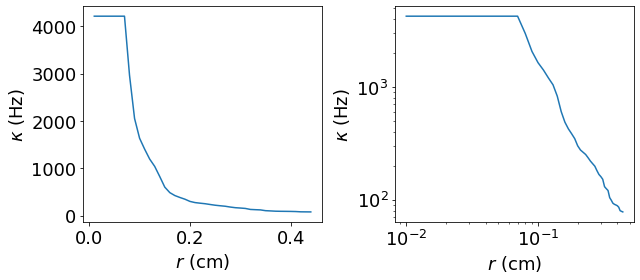

In [87]:
#test kappa for one trajectory / trial
dict_out=compute_kappa_vs_r(input_fn,r_values,DT=DT,**kwargs)
r_values=dict_out['r']
tau_values=dict_out['tau']
#plot apparent r versus kappa
#Nota bene: estimates for kappa with r<0.1cm were shit/constant(~4000Hz) for one particular annihilation event
x=r_values
y=1000/tau_values
fontsize=18
fig,axs=plt.subplots(ncols=2,figsize=(9,4))
ax=axs[0]
ax.plot(x,y)
format_plot(ax, xlabel=r'$r$ (cm)', ylabel=r'$\kappa$ (Hz)', fontsize=fontsize, use_loglog=False)
ax=axs[1]
ax.plot(x,y)
format_plot(ax, xlabel=r'$r$ (cm)', ylabel=r'$\kappa$ (Hz)', fontsize=fontsize, use_loglog=True)
plt.tight_layout()
plt.show()

In [19]:
#TODO: consider a list of r_values
#TODO: compute tau for each r in r_values

In [20]:
#TODO: daskbag over all files in the folder of input_fn
#TODO: return a list of  tdeath_last_further_than_r_values for each annihilation
#TODO: merge that list
#TODO: compute the mean value
#TODO: record 

In [21]:
def routine(input_fn):
    return compute_kappa_vs_r(input_fn,r_values,DT=DT,**kwargs)

In [88]:
r=0.1 #cm
use_test=True
if use_test:
    dict_out=routine(input_fn)
    r_values=dict_out['r']
    tau_values=dict_out['tau']
    tau=tau_values[np.isclose(r_values,r)]
    kappa=1000/np.mean(tau)
    print(f"the apparent value for kappa for this trial was {kappa:.0f} Hz at r={r} cm.")

the apparent value for kappa for this trial was 1633 Hz at r=0.1 cm.


In [89]:
###################################
# Run the daskbag! (~7min run time)
###################################
#find all files matching pattern
trgt_raw='_traj_'
trgt=input_fn[input_fn.find(trgt_raw):]
input_fn_lst=get_all_files_matching_pattern(file=input_fn, trgt=trgt)
print(f"number of files found: {len(input_fn_lst)}")
print(f"token example fn: {input_fn_lst[0]}")
#all CPU version
b = db.from_sequence(input_fn_lst, npartitions=npartitions).map(routine)
start = time.time()
retval = list(b)
print(f"run time for computing mean reaction rate of annihilation events was {time.time()-start:.2f} seconds.")
beep(3)

number of files found: 125
token example fn: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/trajectories/ic014.12_traj_sr_600_mem_0.csv
run time for computing mean reaction rate of annihilation events was 1439.15 seconds.


0

In [90]:
# #format results as a pandas.Dataframe instance
# df=pd.concat([pd.DataFrame(dic) for dic in retval])
# df_routine_out=df.copy()

# #TODO: compute the mean tdeath as tau_avg.  suggest the expected kappa is kappa = 1 / tau_avg
# df['kappa'] = 1000. / df['tau']

# r_values=df['r']
# tau_values=df['tau']
# kappa_values=df['kappa']

In [91]:
#DONE: plot individual kappa density to check for outliers
# g = sns.JointGrid(data=df, x="r", y="kappa")
# g.plot_joint(sns.kdeplot,fill=True)
# g.plot_joint(sns.scatterplot,s=5,alpha=0.2)
# g.plot_marginals(sns.kdeplot)
# # plt.scatter(df['r'].values,df['kappa'].values,s=5,alpha=0.3)
# plt.show()

In [92]:
# #DONE: plot 1/average tau versus r and check for obvious differences
# #DONE: bootstrap the results for kappa
# bins=30
# sdf=df_routine_out.copy()
# df_tau = bin_and_bootstrap_xy_values(x=df['r'].values,
#                                        y=df['tau'].values,
#                                        xlabel='r',
#                                        ylabel='tau',
#                                        bins=bins,
#                                        min_numobs=None,
#                                        num_bootstrap_samples=1000,
#                                        npartitions=npartitions,
#                                      printing=False)
# df=df_tau.copy()
# x_values=df['r'].values
# y_values=1000./df['tau'].values
# y_err_values=1000/df['Delta_tau'].values

# #plot mean radial velocities
# fig, ax = plt.subplots(ncols=1, figsize=(5, 4))

# # def PlotYErrorBar(x_values,y=y_values,yerr=y_err_values):
# #kwargs
# alpha=0.5
# c='C0'
# fontsize=18
# elinewidth=4
# markersize=4
# capsize=200
# xlim=[0, 1]
# x_label=r'r (cm)'
# y_label=r'$\kappa$ (Hz)'

# ax.errorbar(x=x_values,y=y_values,yerr=y_err_values,
#                 c=c,alpha=alpha,fmt='o',markersize=markersize,ecolor=c,elinewidth=elinewidth,errorevery=1,capsize=capsize)
# # #plot fits
# # ax.plot(x_values, y_hat_values, c=c, lw=2, alpha=1, linestyle='solid')

# #format plot
# ax.set_xlim(xlim)
# # ax.set_ylim([-0.5,.1])
# ax.set_xlabel(x_label, fontsize=fontsize)
# ax.set_ylabel(y_label, fontsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=0)

# ax.set_ylim([0,4000])

# ax.set_title(f'tavg1={navg1*DT:.3f} ms\n',fontsize=fontsize)
# plt.tight_layout()
# plt.show()

In [93]:
# #DONE: plot M=pi/2*kappa*r**2 versus r... it didn't look beautiful
# df_kappa['M']=np.pi/2*df_kappa['kappa']*df_kappa['r']**3
# y_values=df_kappa['M']

In [94]:
#format results as a pandas.Dataframe instance
df=pd.concat([pd.DataFrame(dic) for dic in retval])
df_routine_out=df.copy()

#TODO: compute the mean tdeath as tau_avg.  suggest the expected kappa is kappa = 1 / tau_avg
df['kappa'] = 1000. / df['tau']

r_values=df['r']
tau_values=df['tau']
kappa_values=df['kappa']

In [95]:
#print some typical values as a check
print('averaging before taking the inverse...')
for r in [0.1,0.2,0.3]:#cm
    tau=tau_values[np.isclose(r_values,r)]
    kappa=1000/np.mean(tau)#Hz
    print(f"the apparent value for kappa for this trial was {kappa:.0f} Hz at r={r} cm.")
    
#averaging after taking the inverse...
print('\naveraging after taking the inverse...')
for r in [0.1,0.2,0.3]:#cm
    kappa=kappa_values[np.isclose(r_values,r)]
    print(f"the apparent value for kappa for this trial was {np.mean(kappa):.0f} Hz at r={r} cm.")
    

averaging before taking the inverse...
the apparent value for kappa for this trial was 1644 Hz at r=0.1 cm.
the apparent value for kappa for this trial was 529 Hz at r=0.2 cm.
the apparent value for kappa for this trial was 275 Hz at r=0.3 cm.

averaging after taking the inverse...
the apparent value for kappa for this trial was 1981 Hz at r=0.1 cm.
the apparent value for kappa for this trial was 652 Hz at r=0.2 cm.
the apparent value for kappa for this trial was 326 Hz at r=0.3 cm.


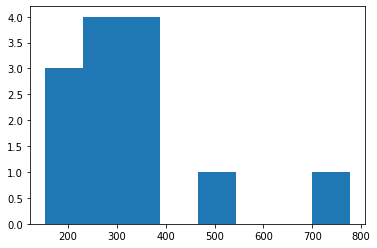

In [96]:
#TODO: filter the high and low rates? No... Don't filter if you want to represent the mean field results...
df=df_routine_out.copy()
plt.hist(kappa_values[np.isclose(r_values,r)],bins=8)
plt.show()

In [97]:
#TOOD(later?): drop data that is larger than kappa>=3000 Hz
#bootstrap the results for kappa
bins=30
df=df_routine_out.copy()
df_tau = bin_and_bootstrap_xy_values(x=df['r'].values,
                                       y=df['tau'].values,
                                       xlabel='r',
                                       ylabel='kappa',
                                       bins=bins,
                                       min_numobs=None,
                                       num_bootstrap_samples=10000,
                                       npartitions=npartitions,printing=False)
df_tau.head()

,r,kappa,Delta_r,Delta_kappa,p_r,p_kappa,counts
0,0.015,0.237500,1.682829e-03,6.867685e-14,0.557220,5.204668e-121,34
1,0.030,0.237500,2.720046e-17,9.659407e-14,0.000000,3.502209e-244,17
2,0.045,0.257353,1.678879e-03,1.409834e-02,0.017934,1.327290e-52,34
3,0.060,0.308088,5.440093e-17,4.593762e-02,0.000000,5.136169e-20,17
4,0.075,0.390441,1.683329e-03,5.193020e-02,0.751088,1.669595e-06,34


In [98]:
#bootstrap the results for kappa
bins=30
df=df_routine_out.copy()
df_kappa = bin_and_bootstrap_xy_values(x=df['r'].values,
                                       y=1000/df['tau'].values,
                                       xlabel='r',
                                       ylabel='kappa',
                                       bins=bins,
                                       min_numobs=None,
                                       num_bootstrap_samples=10000,
                                       npartitions=npartitions,
                                     printing=False)
df_kappa.head()

,r,kappa,Delta_r,Delta_kappa,p_r,p_kappa,counts
0,0.015,4210.526316,1.681476e-03,1.206437e-09,0.106137,6.771903e-131,34
1,0.030,4210.526316,2.720046e-17,1.724296e-09,0.000000,2.827904e-237,17
2,0.045,3964.281054,1.699725e-03,1.634679e+02,0.031117,8.458220e-52,34
3,0.060,3508.040539,5.440093e-17,4.119496e+02,0.000000,1.371024e-16,17
4,0.075,2951.536227,1.700598e-03,3.437842e+02,0.859929,8.302472e-02,34


In [99]:
df=df_kappa.copy()
df.dropna(inplace=True)
x_values=df['r'].values
y_values=df['kappa'].values
y_err_values=df['Delta_kappa'].values

#fit the apparent exponent and magnitude of a powerlaw
xmin=0.15
boo=x_values>xmin
x=np.log(x_values)[boo]
y=np.log(y_values)[boo]
dict_loglog=compute_95CI_ols(x,y)
y_hat_values=np.exp(dict_loglog['b'])*x_values**dict_loglog['m']
print(f"considering ranges from r={np.exp(np.min(x)):.3f} to r={np.exp(np.max(x)):.3f} cm,")
print(f"the apparent exponent for kappa=b*r^m is m={dict_loglog['m']:.3f}+-{dict_loglog['Delta_m']:.3f},")
print(f"the apparent magnitude is b={np.exp(dict_loglog['b']):.3f}+-~~{np.exp(dict_loglog['Delta_b']):.3f} cm^p/s.")
print(f"\nols fit:")
print_dict(dict_loglog)

#save results after bootstrapping
trial_folder_name=os.path.dirname(os.path.dirname(input_fn))
os.chdir(trial_folder_name)
save_fn=f'reaction_rates_bins_{bins}.csv'
df_kappa.to_csv(save_fn,index=False)
print(f"saved results to {os.path.abspath(save_fn)}")

considering ranges from r=0.160 to r=0.430 cm,
the apparent exponent for kappa=b*r^m is m=-1.697+-0.030,
the apparent magnitude is b=41.857+-~~1.040 cm^p/s.

ols fit:
m=-1.696859127781343
Delta_m=0.03036315553775994
b=3.734261877278228
Delta_b=0.0392134280979438
Rsquared=0.9985020009684339
saved results to /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/reaction_rates_bins_30.csv


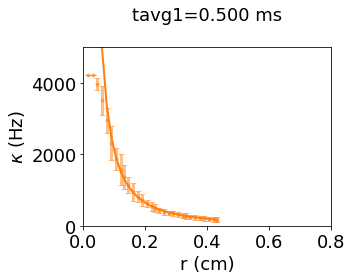

In [104]:
#plot mean radial velocities
fig, ax = plt.subplots(ncols=1, figsize=(5, 4))

# def PlotYErrorBar(x_values,y=y_values,yerr=y_err_values):
#kwargs
alpha=0.5
c='C0'
c='C1'
fontsize=18
elinewidth=3
markersize=3
capsize=3
xlim=[0, 0.8]
ylim=[0,5000]
x_label=r'r (cm)'
y_label=r'$\kappa$ (Hz)'

ax.errorbar(x=x_values,y=y_values,yerr=y_err_values,
                c=c,alpha=alpha,fmt='o',markersize=markersize,ecolor=c,elinewidth=elinewidth,errorevery=1,capsize=capsize)
#plot fits
ax.plot(x_values, y_hat_values, c=c, lw=2, alpha=1, linestyle='solid')

#format plot
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_ylim([-0.5,.1])
ax.set_xlabel(x_label, fontsize=fontsize)
ax.set_ylabel(y_label, fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)


ax.set_title(f'tavg1={navg1*DT:.3f} ms\n',fontsize=fontsize)
plt.tight_layout()
plt.show()

In [101]:
# option A: use two OLS methods
# option B: use my previous wnlfit method IF it has uncertainty built in under the hood (clearly)
#DONE: (i) find the exponent at large r
#DONE: (ii) find the decay rate at large r

Results For the FK model:

considering ranges from r=0.3 to r=0.9 cm,
- the apparent exponent for kappa=B*r^m is m=-2.401+-0.075,
- the apparent magnitude is B=4.314+-0.049 cm^p/s.

In [102]:
#this didn't make sensible results for some reason...
# #compute the apparent magnitude, M supposing the exponent m=2
# # plot_slope_of_emsd?
# #compute the apparent exponent
# m=dict_loglog['m']
# # print(f"m={m}")
# xmin=0.3
# boo=x_values>xmin
# x=x_values[boo].copy()
# y=y_values[boo].copy()*x**m
# # y=np.pi/2*y*x**2
# dict_linlin=compute_95CI_ols(x,y)
# print(f"the apparent magnitude is M={dict_linlin['m']:.3f}+-{dict_linlin['Delta_m']:.3f} cm^p/s")
# print_dict(dict_linlin)

In [103]:
#DOEN: get a function that goes through all the points!
#TODO(later): refine a function that goes through all the points!
#HINT: see my previous wnlfit method. compute RMSE.

## Repeating ^that functional measurement of kappa versus r for the Luo-Rudy model

In [46]:
#load a given file of trajectories
# input_fn=search_for_file()

# # from the FK model with DT=0.025ms
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/trajectories/ic200x200.0.4_traj_sr_600_mem_0.csv"

# # # from the LR model with DT=0.025ms
# # input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/trajectories/ic001.22_traj_sr_600_mem_0.csv"
ds=5
width=200
DT=0.025#ms
pid_col='particle'
t_col='t'
id_col='event_id'

# from the FK model with DT=0.5 ms
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic001.13_traj_sr_600_mem_0.csv"
DT=0.5#ms

#print the termination time
print_termination_time(input_fn);

the termination time was 3.609 seconds.


In [47]:
#print summary stats on particle lifetimes for one input folder
df=pd.read_csv(input_fn)
dft=df.groupby(pid_col)[t_col].describe()
df_lifetimes=-dft[['max','min']].T.diff().loc['min']
print(f"termination time was {df[t_col].max():.2f} ms")

print(f"printing summary stats on particle lifetimes")# for one input folder in {trial_folder_name}:")
print(df_lifetimes.describe())
# print(df_lifetimes.head(10))
print("\nPlease make a manual decision about minimum_lifetime, crop_start_by, and crop_end_by")

termination time was 3609.00 ms
printing summary stats on particle lifetimes
count    1639.000000
mean       15.568944
std        34.690963
min        -0.000000
25%        -0.000000
50%         0.500000
75%        11.750000
max       394.500000
Name: min, dtype: float64

Please make a manual decision about minimum_lifetime, crop_start_by, and crop_end_by


In [50]:
# compute Rkappa versus r
#full model lr (and fk)
min_duration=20#50##20. #ms
min_range   =.1#1.#.2#  #cm  # a pair of particles is considered if their max distance is at least min_range
filter_beginning=True #i think this does nothing...
use_min_duration=False
use_grad_voltage=True
printing=False
range_threshold=.5#0.1 #cm #filter any deaths occurring at ranges exceeding range_threshold
tmin=100#ms
max_dur=500#150#ms#150# #consider no more than the last max_dur milliseconds of either trajectory
round_t_to_n_digits=5
tavg1=0.5 #s
navg1=int(tavg1/DT)
rdeath_thresh=0.7
size_thresh=100
r_values=np.arange(0.01,1.01,0.01) #cm :: the fixed reaction range

# # #particle model
# min_duration=40  #20. #ms # a pair of particles is considered if their lifetime is at least min_range
# min_range   =0  #cm  # a pair of particles is considered if their max distance is at least min_range
# filter_beginning=True
# use_min_duration=True
# use_grad_voltage=False
# range_threshold=10 #cm #filter any deaths occurring at ranges exceeding range_threshold
# round_t_to_n_digits=5
# tmin=0.  #filter all times earlier than tmin? i think so?
# max_dur=0.#ms

npartitions=os.cpu_count()

kwargs={
    'width':width,
    'height':height,
    'ds':ds,
    'printing':False,
    'min_range':min_range,
    'min_duration':min_duration,
    'npartitions':npartitions,
    'filter_beginning':filter_beginning,
    'use_grad_voltage':use_grad_voltage,
    'use_min_duration':use_min_duration,
    'range_threshold':range_threshold,
    'round_t_to_n_digits':round_t_to_n_digits,
    'tmin':tmin,
    'pid_col':pid_col,
    't_col':t_col,
    'max_dur':max_dur,
    'folder_out_name':f'annihilations_mindur_{min_duration}_maxdur_{max_dur}_minrange_{min_range}_rangethresh_{range_threshold}',
    'tavg1':tavg1,
    'rdeath_thresh':rdeath_thresh,
    'size_thresh':size_thresh
}


In [82]:
# dict_out=compute_kappa_vs_r(input_fn,r_values,DT=DT,**kwargs)
# r_values=dict_out['r']
# tau_values=dict_out['tau']
# #plot apparent r versus kappa
# #Nota bene: estimates for kappa with r<0.1cm were shit/constant(~4000Hz) for one particular annihilation event
# x=r_values
# y=1000/tau_values
# fontsize=18
# fig,axs=plt.subplots(ncols=2,figsize=(9,4))
# ax=axs[0]
# ax.plot(x,y)
# format_plot(ax, xlabel=r'$r$ (cm)', ylabel=r'$\kappa$ (Hz)', fontsize=fontsize, use_loglog=False)
# ax=axs[1]
# ax.plot(x,y)
# format_plot(ax, xlabel=r'$r$ (cm)', ylabel=r'$\kappa$ (Hz)', fontsize=fontsize, use_loglog=True)
# plt.tight_layout()
# plt.show()

In [60]:
def routine(input_fn):
    return compute_kappa_vs_r(input_fn,r_values,DT=DT,**kwargs)

In [61]:
r=0.1 #cm
use_test=False
if use_test:
    dict_out=routine(input_fn)
    r_values=dict_out['r']
    tau_values=dict_out['tau']
    tau=tau_values[np.isclose(r_values,r)]
    kappa=1000/np.mean(tau)
    print(f"the apparent value for kappa for this trial was {kappa:.0f} Hz at r={r} cm.")

In [66]:
###################################
# Run the daskbag! (~7min run time)
###################################
#find all files matching pattern
trgt_raw='_traj_'
trgt=input_fn[input_fn.find(trgt_raw):]
input_fn_lst=get_all_files_matching_pattern(file=input_fn, trgt=trgt)
print(f"number of files found: {len(input_fn_lst)}")
print(f"token example fn: {input_fn_lst[0]}")
#all CPU version
b = db.from_sequence(input_fn_lst, npartitions=npartitions).map(routine)
start = time.time()
retval = list(b)
print(f"run time for computing mean reaction rate of annihilation events was {time.time()-start:.2f} seconds.")
beep(3)

number of files found: 159
token example fn: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic014.12_traj_sr_600_mem_0.csv
run time for computing mean reaction rate of annihilation events was 598.32 seconds.


0

In [67]:
#TODO: estimate how many events actually were used...

In [68]:
# #format results as a pandas.Dataframe instance
# df=pd.concat([pd.DataFrame(dic) for dic in retval])
# df_routine_out=df.copy()

# #TODO: compute the mean tdeath as tau_avg.  suggest the expected kappa is kappa = 1 / tau_avg
# df['kappa'] = 1000. / df['tau']

# r_values=df['r']
# tau_values=df['tau']
# kappa_values=df['kappa']

In [69]:
#DONE: plot individual kappa density to check for outliers
# g = sns.JointGrid(data=df, x="r", y="kappa")
# g.plot_joint(sns.kdeplot,fill=True)
# g.plot_joint(sns.scatterplot,s=5,alpha=0.2)
# g.plot_marginals(sns.kdeplot)
# # plt.scatter(df['r'].values,df['kappa'].values,s=5,alpha=0.3)
# plt.show()

In [70]:
# #DONE: plot 1/average tau versus r and check for obvious differences
# #DONE: bootstrap the results for kappa
# bins=30
# sdf=df_routine_out.copy()
# df_tau = bin_and_bootstrap_xy_values(x=df['r'].values,
#                                        y=df['tau'].values,
#                                        xlabel='r',
#                                        ylabel='tau',
#                                        bins=bins,
#                                        min_numobs=None,
#                                        num_bootstrap_samples=1000,
#                                        npartitions=npartitions,
#                                      printing=False)
# df=df_tau.copy()
# x_values=df['r'].values
# y_values=1000./df['tau'].values
# y_err_values=1000/df['Delta_tau'].values

# #plot mean radial velocities
# fig, ax = plt.subplots(ncols=1, figsize=(5, 4))

# # def PlotYErrorBar(x_values,y=y_values,yerr=y_err_values):
# #kwargs
# alpha=0.5
# c='C0'
# fontsize=18
# elinewidth=4
# markersize=4
# capsize=200
# xlim=[0, 1]
# x_label=r'r (cm)'
# y_label=r'$\kappa$ (Hz)'

# ax.errorbar(x=x_values,y=y_values,yerr=y_err_values,
#                 c=c,alpha=alpha,fmt='o',markersize=markersize,ecolor=c,elinewidth=elinewidth,errorevery=1,capsize=capsize)
# # #plot fits
# # ax.plot(x_values, y_hat_values, c=c, lw=2, alpha=1, linestyle='solid')

# #format plot
# ax.set_xlim(xlim)
# # ax.set_ylim([-0.5,.1])
# ax.set_xlabel(x_label, fontsize=fontsize)
# ax.set_ylabel(y_label, fontsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=0)

# ax.set_ylim([0,4000])

# ax.set_title(f'tavg1={navg1*DT:.3f} ms\n',fontsize=fontsize)
# plt.tight_layout()
# plt.show()

In [71]:
# #DONE: plot M=pi/2*kappa*r**2 versus r... it didn't look beautiful
# df_kappa['M']=np.pi/2*df_kappa['kappa']*df_kappa['r']**3
# y_values=df_kappa['M']

In [72]:
#format results as a pandas.Dataframe instance
df=pd.concat([pd.DataFrame(dic) for dic in retval])
df_routine_out=df.copy()

#TODO: compute the mean tdeath as tau_avg.  suggest the expected kappa is kappa = 1 / tau_avg
df['kappa'] = 1000. / df['tau']

df.dropna(inplace=True)
r_values=df['r']
tau_values=df['tau']
kappa_values=df['kappa']

In [73]:
#print some typical values as a check
print('averaging before taking the inverse...')
for r in [0.1,0.2,0.3]:#cm
    tau=tau_values[np.isclose(r_values,r)]
    kappa=1000/np.mean(tau)#Hz
    print(f"the apparent value for kappa for this trial was {kappa:.0f} Hz at r={r} cm.")
    
#averaging after taking the inverse...
print('\naveraging after taking the inverse...')
for r in [0.1,0.2,0.3]:#cm
    kappa=kappa_values[np.isclose(r_values,r)]
    print(f"the apparent value for kappa for this trial was {np.mean(kappa):.0f} Hz at r={r} cm.")
    

averaging before taking the inverse...
the apparent value for kappa for this trial was 2714 Hz at r=0.1 cm.
the apparent value for kappa for this trial was 589 Hz at r=0.2 cm.
the apparent value for kappa for this trial was 185 Hz at r=0.3 cm.

averaging after taking the inverse...
the apparent value for kappa for this trial was inf Hz at r=0.1 cm.
the apparent value for kappa for this trial was inf Hz at r=0.2 cm.
the apparent value for kappa for this trial was 474 Hz at r=0.3 cm.


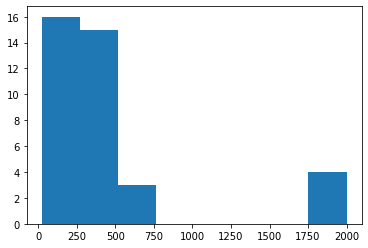

In [74]:
#TODO: filter the high and low rates? No... Don't filter if you want to represent the mean field results...
df=df_routine_out.copy()
plt.hist(kappa_values[np.isclose(r_values,r)],bins=8)
plt.show()

In [75]:
#TOOD(later?): drop data that is larger than kappa>=3000 Hz

#bootstrap the results for kappa
bins=30
df=df_routine_out.copy()
df_tau = bin_and_bootstrap_xy_values(x=df['r'].values,
                                       y=df['tau'].values,
                                       xlabel='r',
                                       ylabel='kappa',
                                       bins=bins,
                                       min_numobs=None,
                                       num_bootstrap_samples=10000,
                                       npartitions=npartitions,printing=False)
df_tau.head()

,r,kappa,Delta_r,Delta_kappa,p_r,p_kappa,counts
0,0.025,0.075658,0.001757,0.028921,0.670257,1.833864e-16,152
1,0.060,0.232456,0.001504,0.045832,0.301234,5.101441e-01,114
2,0.090,0.333333,0.001486,0.051214,0.374669,6.331009e-01,114
3,0.125,0.595395,0.001772,0.074753,0.845416,4.288320e-18,152
4,0.160,0.916667,0.001485,0.113971,0.352066,2.144727e-12,114


In [76]:
#bootstrap the results for kappa
bins=30
sdf=df_routine_out.copy()
df_kappa = bin_and_bootstrap_xy_values(x=df['r'].values,
                                       y=1000/df['tau'].values,
                                       xlabel='r',
                                       ylabel='kappa',
                                       bins=bins,
                                       min_numobs=None,
                                       num_bootstrap_samples=10000,
                                       npartitions=npartitions,
                                     printing=False)
df_kappa.head()

,r,kappa,Delta_r,Delta_kappa,p_r,p_kappa,counts
0,0.025,inf,0.001781,NaN,0.752364,NaN,152
1,0.060,inf,0.001497,NaN,0.270185,NaN,114
2,0.090,inf,0.001496,NaN,0.036264,NaN,114
3,0.125,inf,0.001791,NaN,0.838067,NaN,152
4,0.160,inf,0.001505,NaN,0.345043,NaN,114


In [78]:
df=df_kappa.copy()
df.dropna(inplace=True)
x_values=df['r'].values
y_values=df['kappa'].values
y_err_values=df['Delta_kappa'].values

#fit the apparent exponent and magnitude of a powerlaw
xmin=0.15
boo=x_values>xmin
x=np.log(x_values)[boo]
y=np.log(y_values)[boo]
dict_loglog=compute_95CI_ols(x,y)
y_hat_values=np.exp(dict_loglog['b'])*x_values**dict_loglog['m']
print(f"considering ranges from r={np.exp(np.min(x)):.3f} to r={np.exp(np.max(x)):.3f} cm,")
print(f"the apparent exponent for kappa=b*r^m is m={dict_loglog['m']:.3f}+-{dict_loglog['Delta_m']:.3f},")
print(f"the apparent magnitude is b={np.exp(dict_loglog['b']):.3f}+-{np.exp(dict_loglog['Delta_b']):.3f} cm^p/s.")
print(f"\nols fit:")
print_dict(dict_loglog)

#save results after bootstrapping
trial_folder_name=os.path.dirname(os.path.dirname(input_fn))
os.chdir(trial_folder_name)
save_fn=f'reaction_rates_bins_{bins}.csv'
df_kappa.to_csv(save_fn,index=False)
print(f"saved results to {os.path.abspath(save_fn)}")

considering ranges from r=0.260 to r=0.980 cm,
the apparent exponent for kappa=b*r^m is m=-0.401+-0.131,
the apparent magnitude is b=263.930+-~~1.093 cm^p/s.

ols fit:
m=-0.4014942205769435
Delta_m=0.13137727178364283
b=5.575684418594762
Delta_b=0.08849889050407513
Rsquared=0.6307897971803853


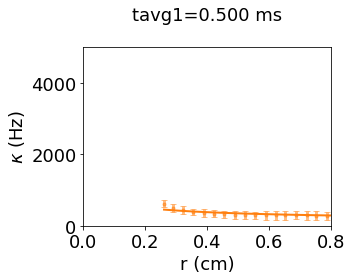

In [83]:
#plot mean radial velocities
fig, ax = plt.subplots(ncols=1, figsize=(5, 4))

# def PlotYErrorBar(x_values,y=y_values,yerr=y_err_values):
#kwargs
alpha=0.5
c='C1'
fontsize=18
elinewidth=3
markersize=3
capsize=3
xlim=[0, 0.8]
ylim=[0,5000]
x_label=r'r (cm)'
y_label=r'$\kappa$ (Hz)'

ax.errorbar(x=x_values,y=y_values,yerr=y_err_values,
                c=c,alpha=alpha,fmt='o',markersize=markersize,ecolor=c,elinewidth=elinewidth,errorevery=1,capsize=capsize)
#plot fits
ax.plot(x_values, y_hat_values, c=c, lw=2, alpha=1, linestyle='solid')

#format plot
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_ylim([-0.5,.1])
ax.set_xlabel(x_label, fontsize=fontsize)
ax.set_ylabel(y_label, fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)


ax.set_title(f'tavg1={navg1*DT:.3f} ms\n',fontsize=fontsize)
plt.tight_layout()
plt.show()

In [80]:
# option A: use two OLS methods
# option B: use my previous wnlfit method IF it has uncertainty built in under the hood (clearly)
#DONE: (i) find the exponent at large r
#DONE: (ii) find the decay rate at large r

Results For the FK model:

considering ranges from r=0.3 to r=0.9 cm,
- the apparent exponent for kappa=B*r^m is m=-2.401+-0.075,
- the apparent magnitude is B=4.314+-0.049 cm^p/s.

In [81]:
#this didn't make sensible results for some reason...
# #compute the apparent magnitude, M supposing the exponent m=2
# # plot_slope_of_emsd?
# #compute the apparent exponent
# m=dict_loglog['m']
# # print(f"m={m}")
# xmin=0.3
# boo=x_values>xmin
# x=x_values[boo].copy()
# y=y_values[boo].copy()*x**m
# # y=np.pi/2*y*x**2
# dict_linlin=compute_95CI_ols(x,y)
# print(f"the apparent magnitude is M={dict_linlin['m']:.3f}+-{dict_linlin['Delta_m']:.3f} cm^p/s")
# print_dict(dict_linlin)

In [566]:
#DOEN: get a function that goes through all the points!
#TODO(later): refine a function that goes through all the points!
#HINT: see my previous wnlfit method. compute RMSE.